**Description**     
In this notebook, I'm exploring data downloaded via the Google analytics API.       
The uploaded data is converted to a DataFrame, which is then modified (data types, columns).        
The websites of interest are filtered out from the df.      
These are further evaluated (individually and in groups).       

**Required libraries**

In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

**Data upload**

In [104]:
# Dataset containing data in the period - 2023-11-01 - 2024-11-30 
df = pd.read_json("../3_data/processed_data/df_analytics.json")

In [105]:
df.head(5)

website  year  month  active_users  new_users  sessions  \
0  agro-obchody.sk  2023     11            22         20        27   
1  agro-obchody.sk  2023     12            18         17        21   
2  agro-obchody.sk  2024      1            49         46        72   
3  agro-obchody.sk  2024      2            34         33        35   
4  agro-obchody.sk  2024      3            29         28        32   

   sessions_per_user  screen_page_views  engaged_sessions  \
0           1.227273                 17                 6   
1           1.166667                 19                14   
2           1.469388                 70                40   
3           1.029412                 31                14   
4           1.103448                 28                11   

   average_session_duration  
0                 17.465142  
1                194.068334  
2                251.915855  
3                 34.211192  
4                 33.560539

In [106]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   website                   264 non-null    object 
 1   year                      264 non-null    int64  
 2   month                     264 non-null    int64  
 3   active_users              264 non-null    int64  
 4   new_users                 264 non-null    int64  
 5   sessions                  264 non-null    int64  
 6   sessions_per_user         264 non-null    float64
 7   screen_page_views         264 non-null    int64  
 8   engaged_sessions          264 non-null    int64  
 9   average_session_duration  264 non-null    float64
dtypes: float64(2), int64(7), object(1)
memory usage: 20.8+ KB


**Defining key KPIs**   
active_users    
new_users   
sessions_per_user   
average_session_duration    
engagement_rate = engaged_sessions / sessions   
new_users_ratio = new_users / active_users  

In [107]:
# Calculation of KPIs
df["engagement_rate"] = df["engaged_sessions"] / df["sessions"]
df["new_users_ratio"] = df["new_users"] / df["active_users"]


**Data processing**

In [108]:
# Float64 values rounding
columns_to_round = [
    "sessions_per_user",
    "average_session_duration",
    "engagement_rate",
    "new_users_ratio",
]

df[columns_to_round] = df[columns_to_round].round(2)

# Create a new column year_month
df.insert(loc=1, column='year_month', value=pd.to_datetime(df[['year', 'month']].assign(day=1)).dt.strftime('%Y-%m'))

**Data filtering**

In [109]:
# Websites of interest
websites = [
    "zemedelec.cz",
    "profipress.cz",
    "mechanizacezemedelstvi.cz", 
    "komunalweb.cz",
    "moderniobec.cz",
    "naschov.cz", 
    "odpady-online.cz",
    "vetweb.cz",
    "tvzemedelec.cz",
    "zahradaweb.cz",
]

# Data filtering
df_websites = df[df["website"].isin(websites)]

In [110]:
df_websites.info()

<class 'pandas.core.frame.DataFrame'>
Index: 130 entries, 87 to 263
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   website                   130 non-null    object 
 1   year_month                130 non-null    object 
 2   year                      130 non-null    int64  
 3   month                     130 non-null    int64  
 4   active_users              130 non-null    int64  
 5   new_users                 130 non-null    int64  
 6   sessions                  130 non-null    int64  
 7   sessions_per_user         130 non-null    float64
 8   screen_page_views         130 non-null    int64  
 9   engaged_sessions          130 non-null    int64  
 10  average_session_duration  130 non-null    float64
 11  engagement_rate           130 non-null    float64
 12  new_users_ratio           130 non-null    float64
dtypes: float64(4), int64(7), object(2)
memory usage: 14.2+ KB


**Data exploration**        
Variables and functions

In [111]:
metrics = [
    "active_users",
    "new_users",
    "sessions_per_user",
    "average_session_duration",
    "engagement_rate",
    "new_users_ratio",
]

In [112]:
sns.set_theme(
    style="whitegrid",
    palette="deep",
    font_scale=1.1,
    rc={"grid.color": "#e6e6e6"},
)

In [113]:
def get_report(df_website):
    """Functions for calculating and displaying average and total values.
    Display the months with the most number of active users"""
    
    print("Average per month:")
    for metric in metrics:
        print(f"  {metric}: {df_website[metric].mean().round(2)}")

    print("\nTotal per year:")
    for metric in ["active_users", "new_users"]:
        print(f"  {metric}: {df_website[metric].sum()}")

    top_rows = df_website.nlargest(3, 'active_users')
    return top_rows.head(3)

In [114]:
def get_report_charts(df_website):
    """Functions for creating graphs - FacetGrid for individual metrics, line chart for groups of metrics"""

    # 1) FacetGrid - line chart for each metric separately 
    df_melted = df_website.melt(id_vars=['year_month'], 
                                value_vars=metrics,
                                var_name='Metric', 
                                value_name='Value')

    grid = sns.FacetGrid(df_melted, col='Metric', col_wrap=2, sharey=False, height=4, aspect=1.5)
    grid.map(sns.lineplot, 'year_month', 'Value', linewidth=2)
    grid.set_titles("{col_name}") 
    grid.set_axis_labels("Date", "Value")
    grid.set(ylim=(0, None))

    for ax in grid.axes.flat:
        ax.tick_params(axis='x', rotation=45)  

    plt.suptitle("Trend of individual metrics over the year")
    plt.tight_layout()
    plt.show()

    # 2) Line chart - Active and new users
    plt.figure(figsize=(10, 5))
    sns.lineplot(data=df_website, x="year_month", y="active_users", label="Active Users", linewidth=2)
    sns.lineplot(data=df_website, x="year_month", y="new_users", label="New Users")
    plt.title("Active and new users over the year")
    plt.xlabel("") 
    plt.ylabel("Number of users")
    plt.xticks(rotation=45, ha="right")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 3) Line chart - Average session duration
    plt.figure(figsize=(10, 5))
    sns.lineplot(data=df_website, x="year_month", y="average_session_duration", label="Average session duration", linewidth=2)
    plt.title("Average session duration over the year")
    plt.ylabel("Seconds")
    plt.xticks(rotation=45, ha="right")
    plt.xlabel("")
    plt.tight_layout()
    plt.show()

    # Line chart - User engagement metrics
    plt.figure(figsize=(10, 5))
    sns.lineplot(data=df_website, x="year_month", y="sessions_per_user", label="Sessions per user", linewidth=2)
    sns.lineplot(data=df_website, x="year_month", y="engagement_rate", label="Engagement rate", linewidth=2)
    sns.lineplot(data=df_website, x="year_month", y="new_users_ratio", label="New Users ratio", linewidth=2)
    plt.title("User engagement metrics over year")
    plt.xticks(rotation=45, ha="right")  
    plt.xlabel("")  
    plt.ylabel("Ratio")
    plt.legend()
    plt.tight_layout()
    plt.show()

**Website zemedelec.cz**

In [115]:
df_zemedelec = df_websites[df_websites["website"] == "zemedelec.cz"]

In [116]:
get_report(df_zemedelec)

Average per month:
  active_users: 13605.15
  new_users: 12734.0
  sessions_per_user: 1.26
  average_session_duration: 125.0
  engagement_rate: 0.62
  new_users_ratio: 0.93

Total per year:
  active_users: 176867
  new_users: 165542


website year_month  year  month  active_users  new_users  sessions  \
254  zemedelec.cz    2024-02  2024      2         17829      16841     23220   
253  zemedelec.cz    2024-01  2024      1         15557      14516     19630   
255  zemedelec.cz    2024-03  2024      3         15339      14086     19575   

     sessions_per_user  screen_page_views  engaged_sessions  \
254               1.30               1645             15067   
253               1.26               4159             12614   
255               1.28               1218             12814   

     average_session_duration  engagement_rate  new_users_ratio  
254                    126.69             0.65             0.94  
253                    140.75             0.64             0.93  
255                    136.85             0.65             0.92

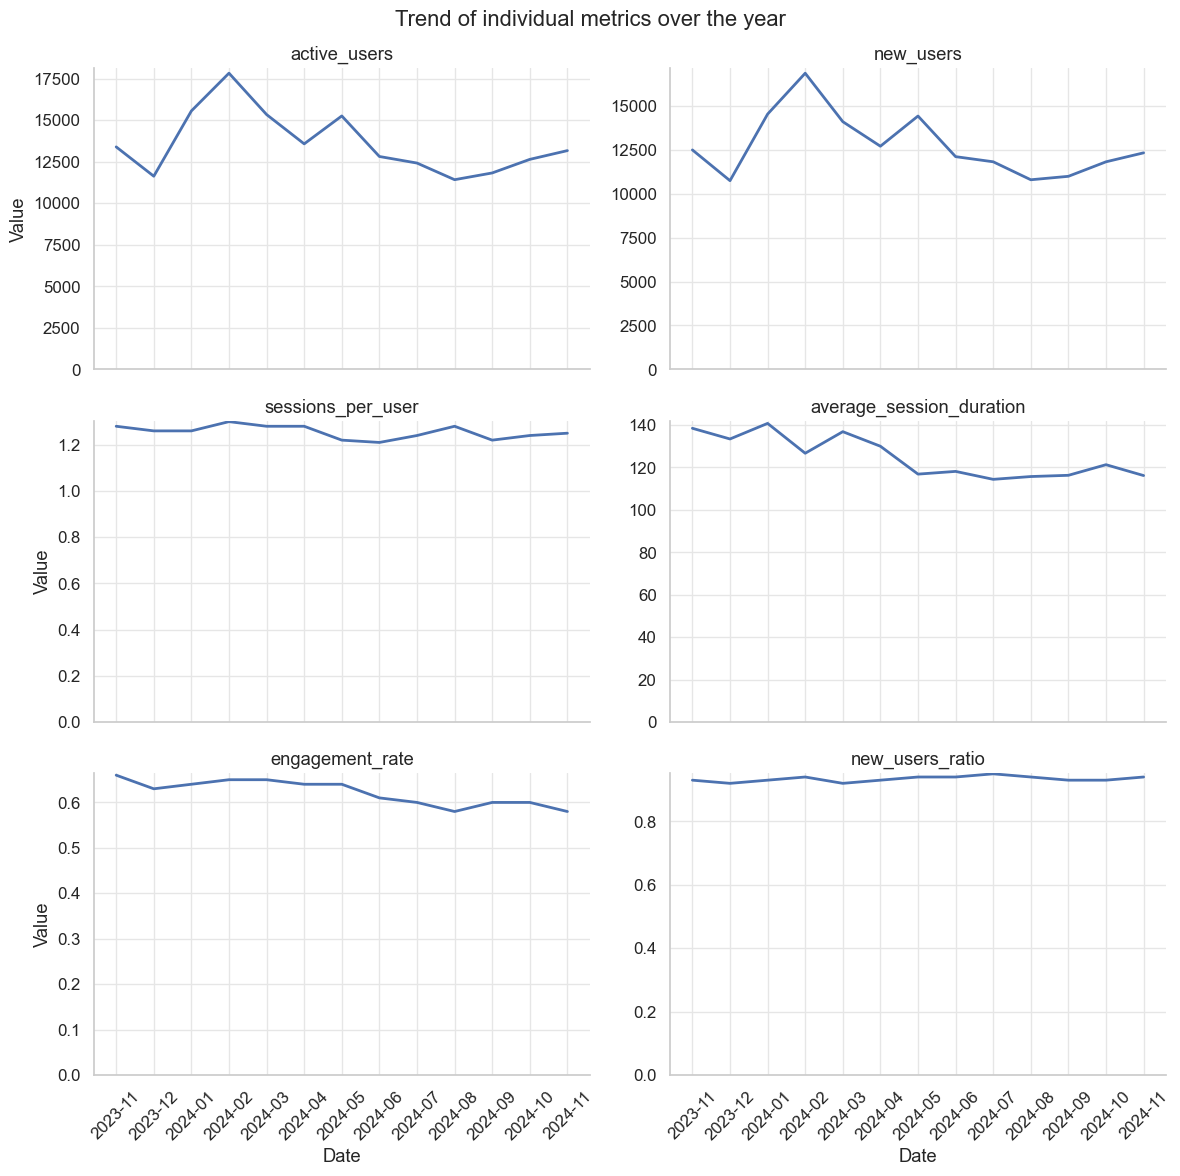

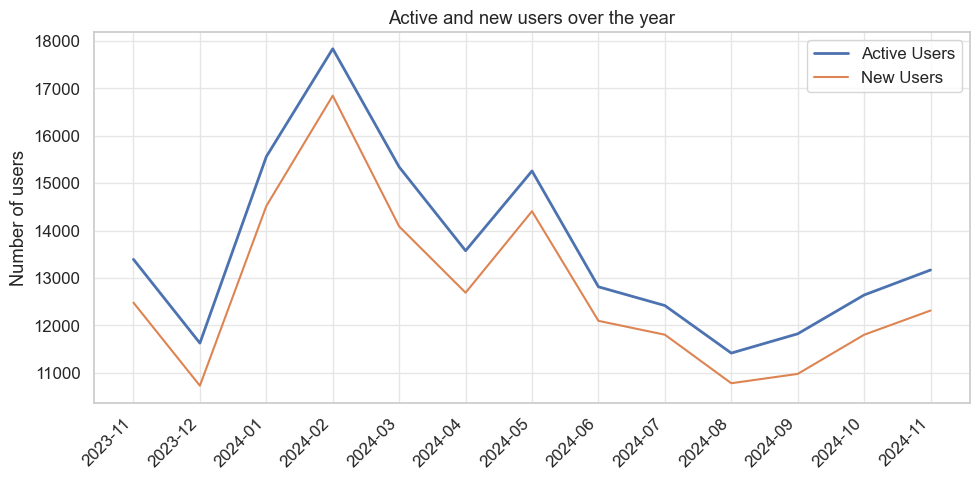

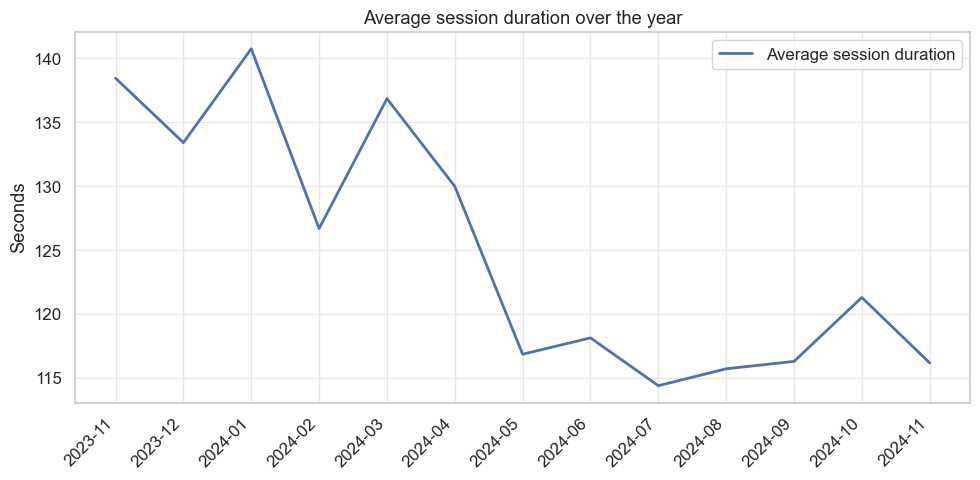

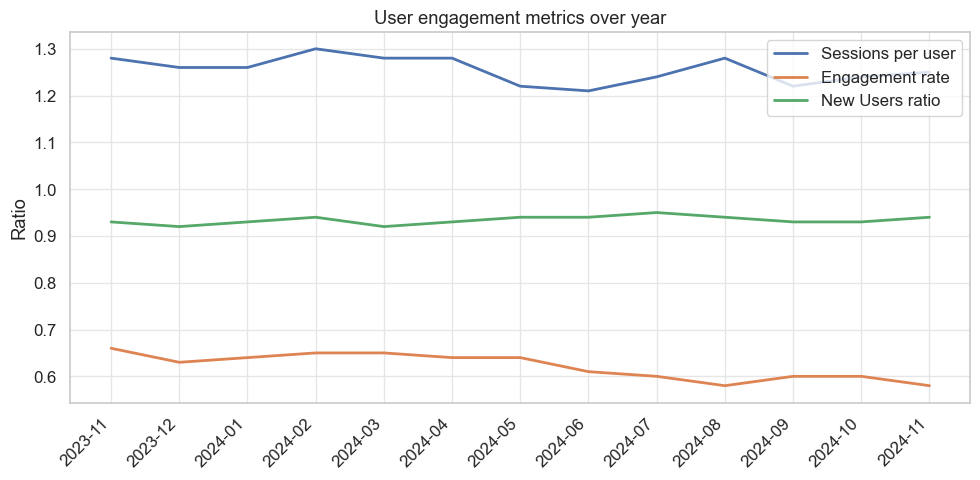

In [117]:
get_report_charts(df_zemedelec)

**Website profipress.cz**

In [118]:
df_profipress = df_websites[df_websites["website"] == "profipress.cz"]

In [119]:
get_report(df_profipress)

Average per month:
  active_users: 4138.69
  new_users: 3535.85
  sessions_per_user: 1.78
  average_session_duration: 166.02
  engagement_rate: 0.59
  new_users_ratio: 0.85

Total per year:
  active_users: 53803
  new_users: 45966


website year_month  year  month  active_users  new_users  sessions  \
180  profipress.cz    2024-02  2024      2          5960       5212     10512   
181  profipress.cz    2024-03  2024      3          4959       4176      9419   
179  profipress.cz    2024-01  2024      1          4471       3805      8460   

     sessions_per_user  screen_page_views  engaged_sessions  \
180               1.76               1430              6628   
181               1.90                741              6092   
179               1.89                925              5467   

     average_session_duration  engagement_rate  new_users_ratio  
180                    197.97             0.63             0.87  
181                    196.40             0.65             0.84  
179                    184.04             0.65             0.85

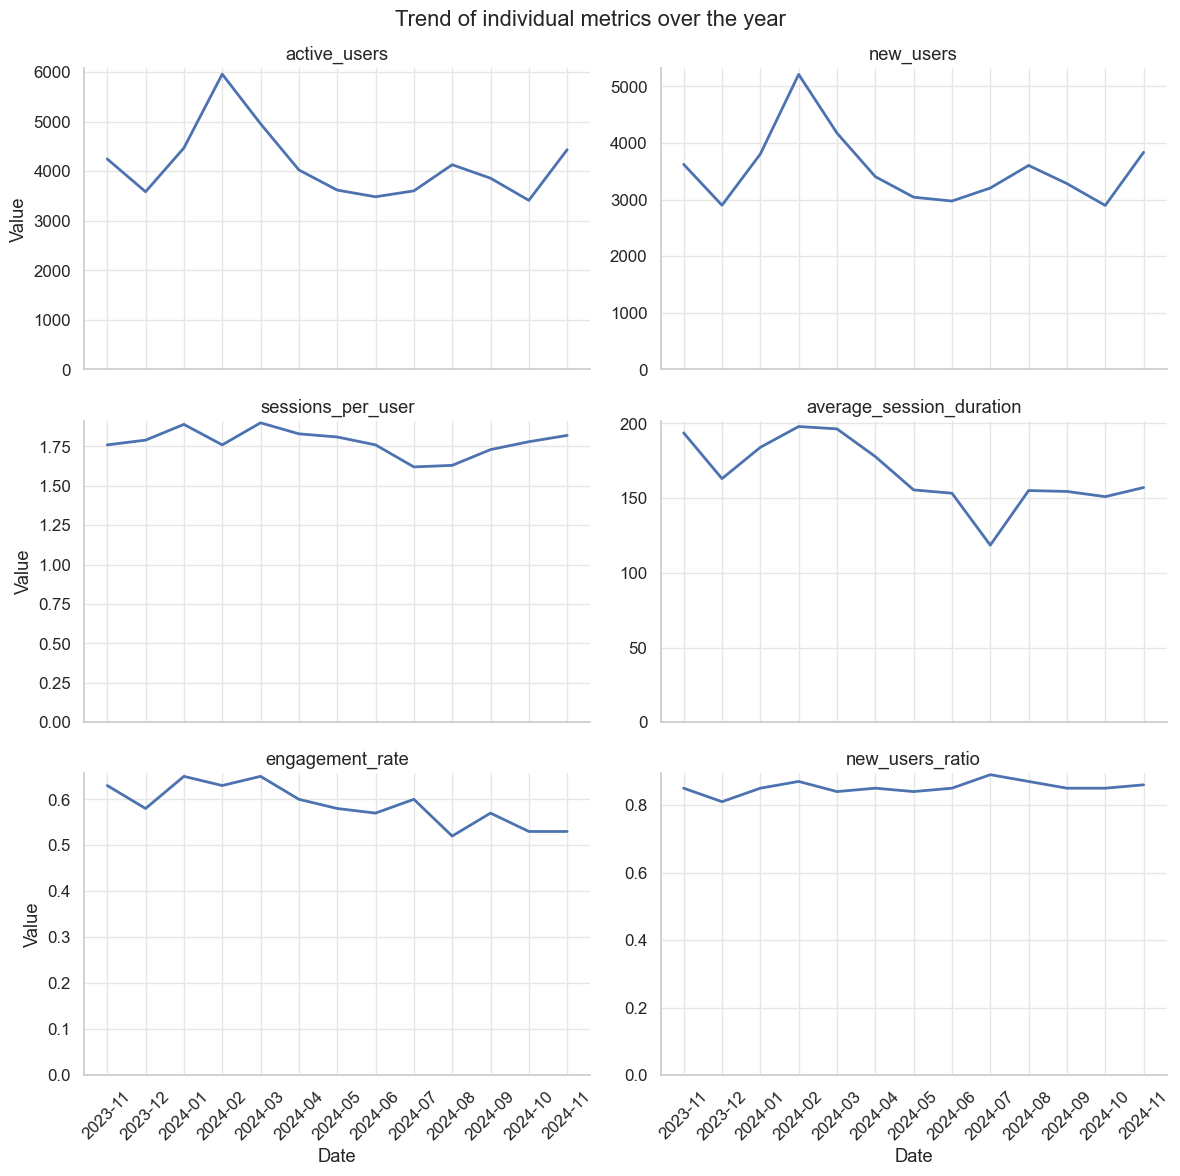

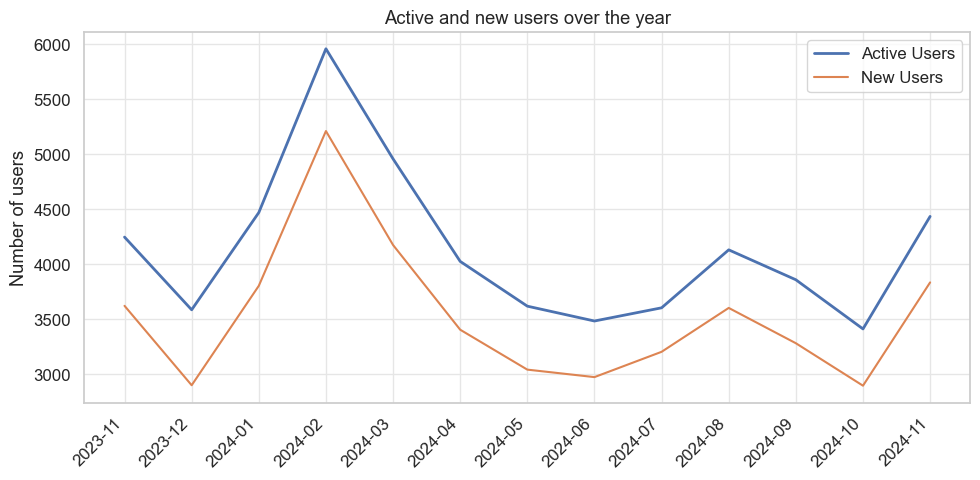

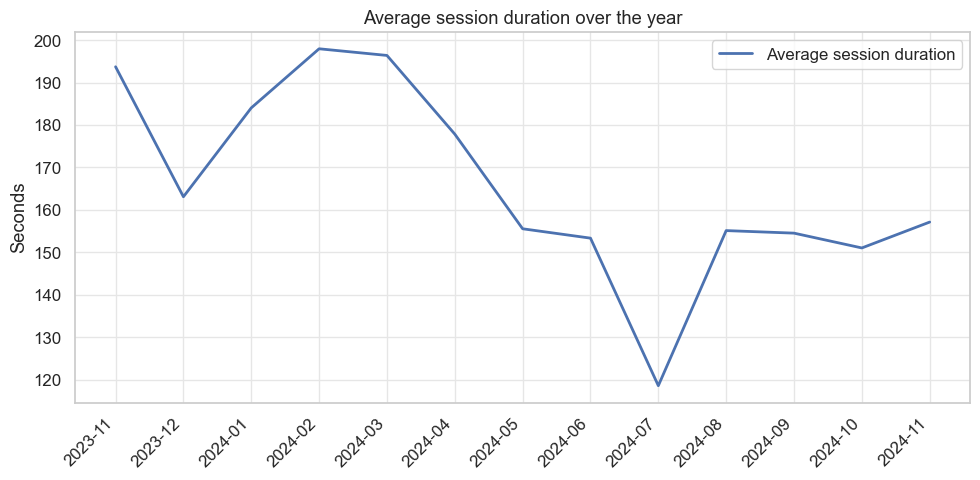

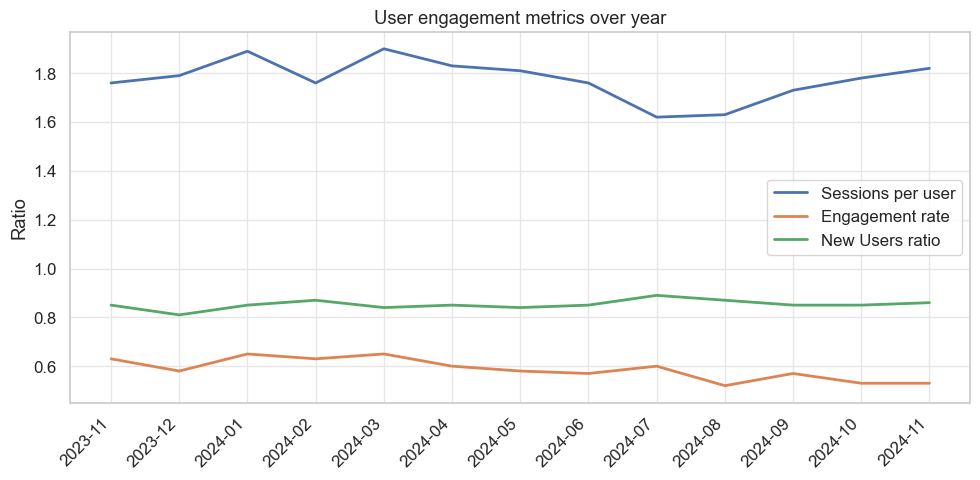

In [120]:
get_report_charts(df_profipress)

**Website mechanizacezemedelstvi.cz**

In [121]:
df_mechanizace = df_websites[df_websites["website"] == "mechanizacezemedelstvi.cz"]

In [122]:
get_report(df_mechanizace)

Average per month:
  active_users: 5269.69
  new_users: 4781.46
  sessions_per_user: 1.4
  average_session_duration: 139.29
  engagement_rate: 0.64
  new_users_ratio: 0.91

Total per year:
  active_users: 68506
  new_users: 62159


website year_month  year  month  active_users  \
105  mechanizacezemedelstvi.cz    2024-04  2024      4          6085   
106  mechanizacezemedelstvi.cz    2024-05  2024      5          5836   
104  mechanizacezemedelstvi.cz    2024-03  2024      3          5804   

     new_users  sessions  sessions_per_user  screen_page_views  \
105       5523      8390               1.38                715   
106       5341      7942               1.36                727   
104       5257      8385               1.44                784   

     engaged_sessions  average_session_duration  engagement_rate  \
105              5358                    136.61             0.64   
106              4990                    125.40             0.63   
104              5436                    163.09             0.65   

     new_users_ratio  
105             0.91  
106             0.92  
104             0.91

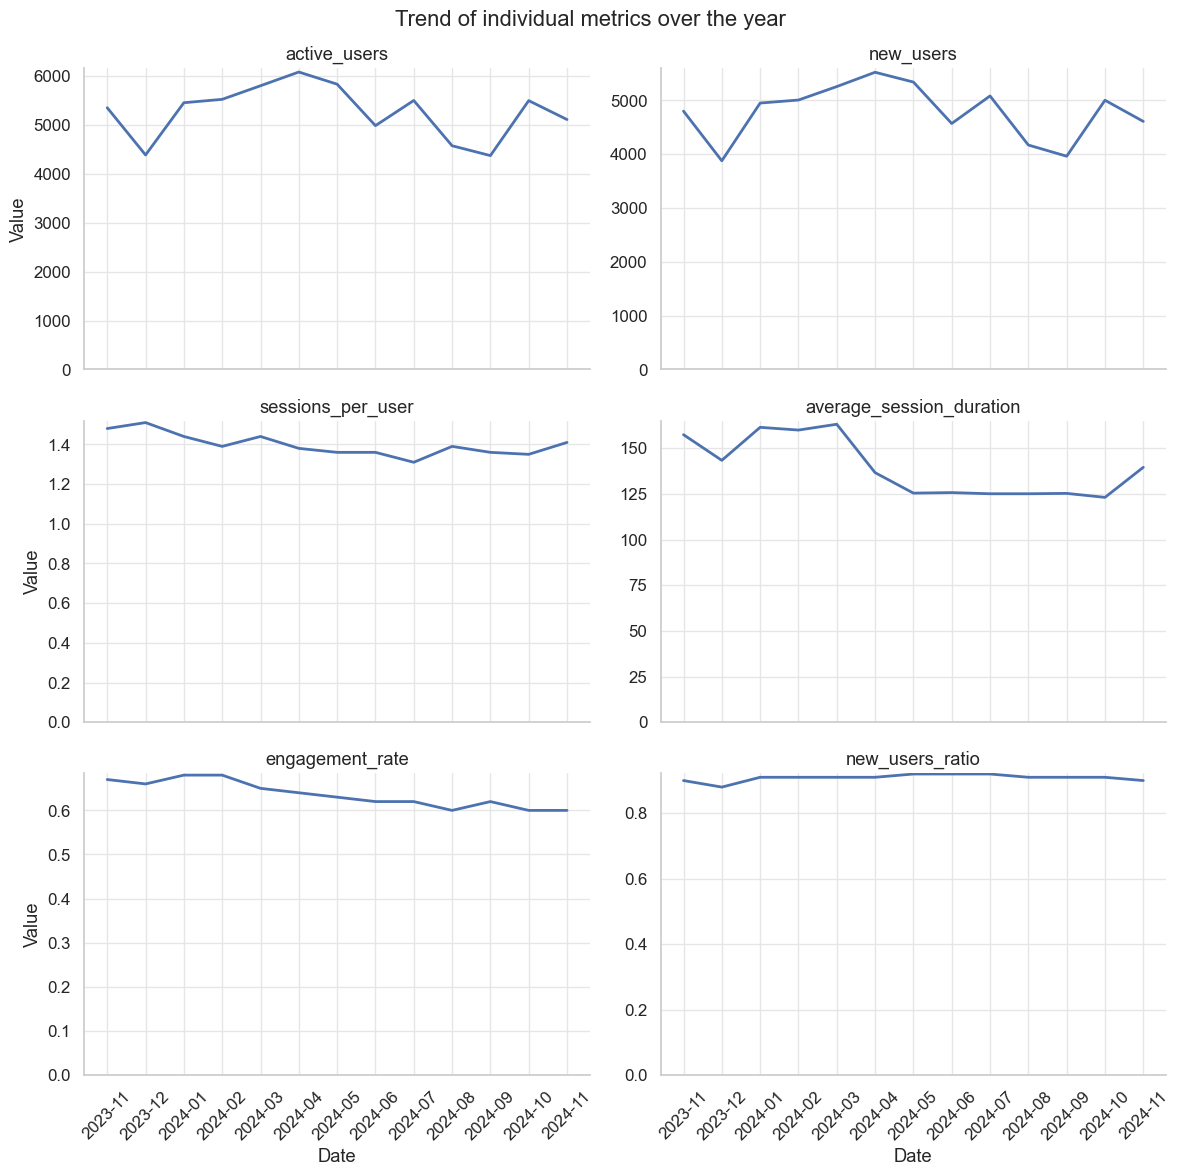

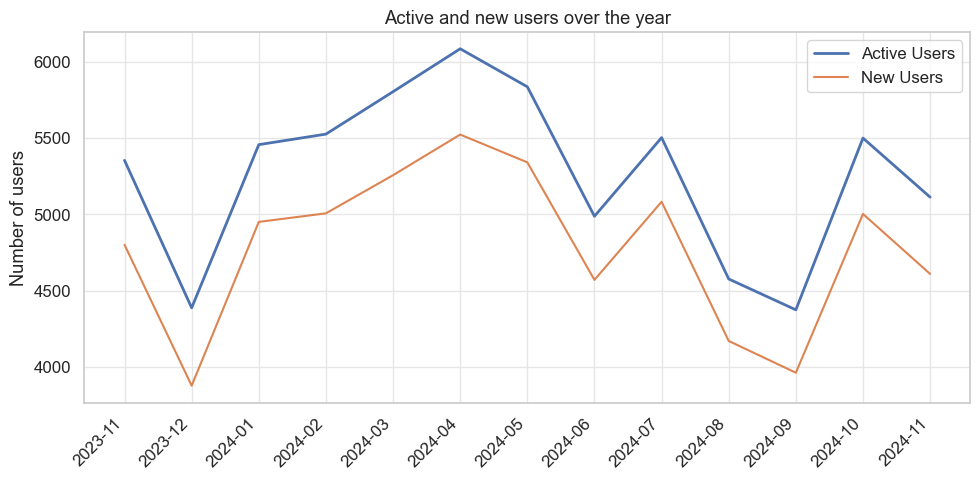

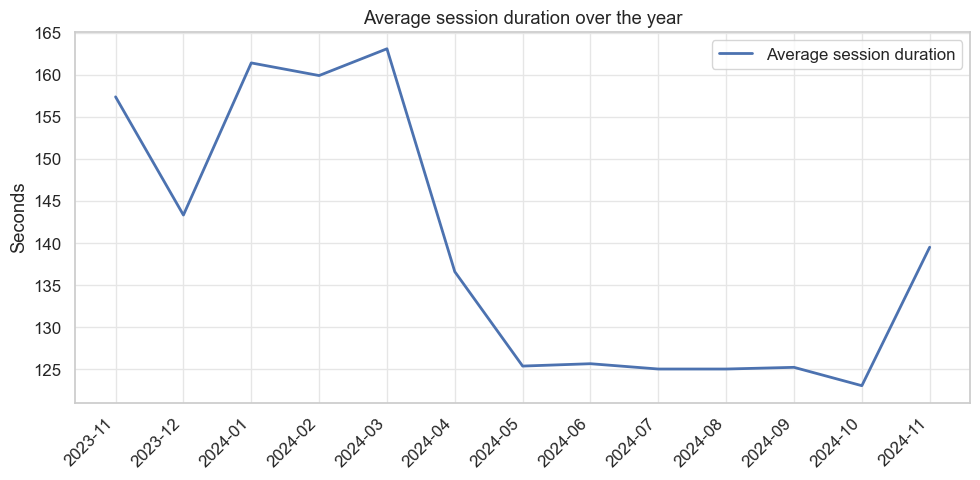

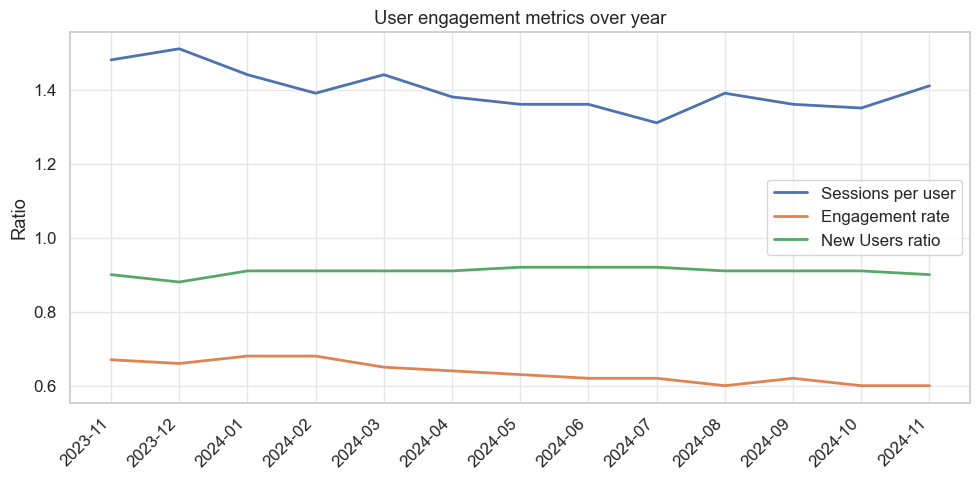

In [123]:
get_report_charts(df_mechanizace)

**Website komunalweb.cz**

In [124]:
df_komunalweb = df_websites[df_websites["website"] == "komunalweb.cz"]

In [125]:
get_report(df_komunalweb)

Average per month:
  active_users: 2441.38
  new_users: 2356.92
  sessions_per_user: 1.15
  average_session_duration: 122.39
  engagement_rate: 0.65
  new_users_ratio: 0.97

Total per year:
  active_users: 31738
  new_users: 30640


website year_month  year  month  active_users  new_users  sessions  \
92  komunalweb.cz    2024-04  2024      4          3034       2946      3501   
91  komunalweb.cz    2024-03  2024      3          2953       2852      3374   
93  komunalweb.cz    2024-05  2024      5          2832       2748      3175   

    sessions_per_user  screen_page_views  engaged_sessions  \
92               1.15                298              2389   
91               1.14                261              2316   
93               1.12                310              2178   

    average_session_duration  engagement_rate  new_users_ratio  
92                    117.02             0.68             0.97  
91                    120.38             0.69             0.97  
93                    124.33             0.69             0.97

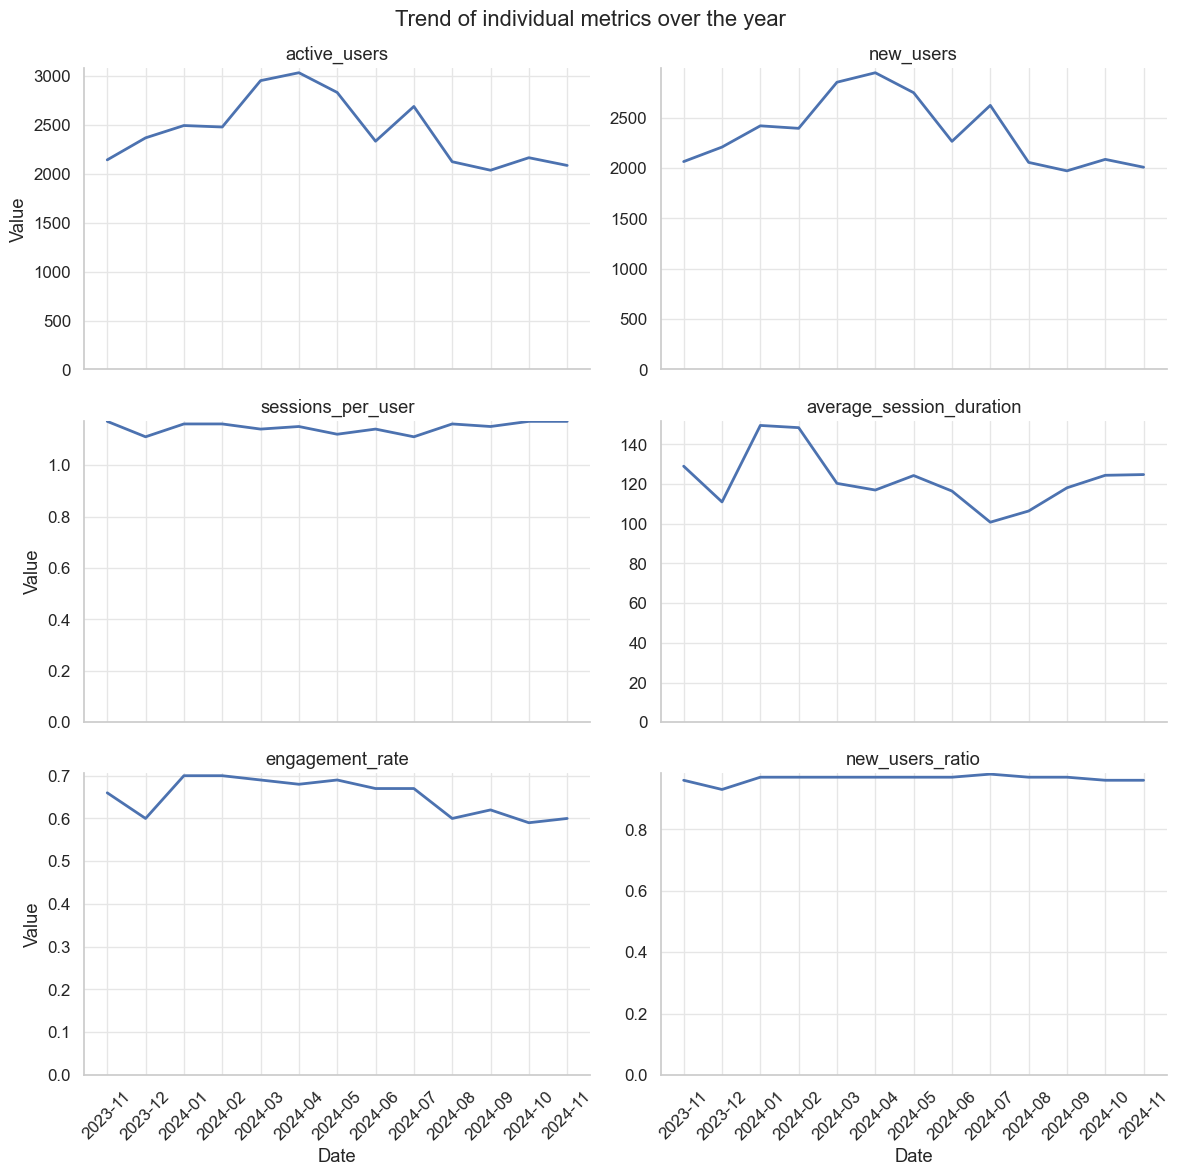

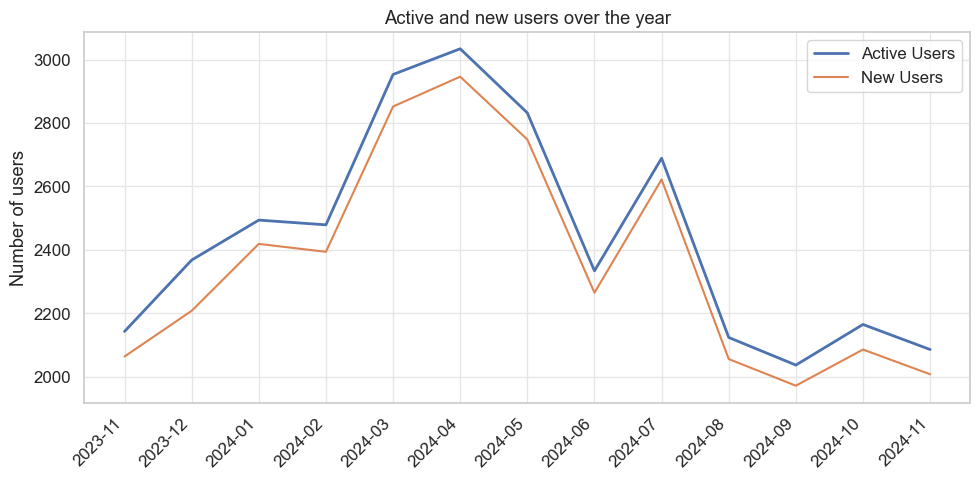

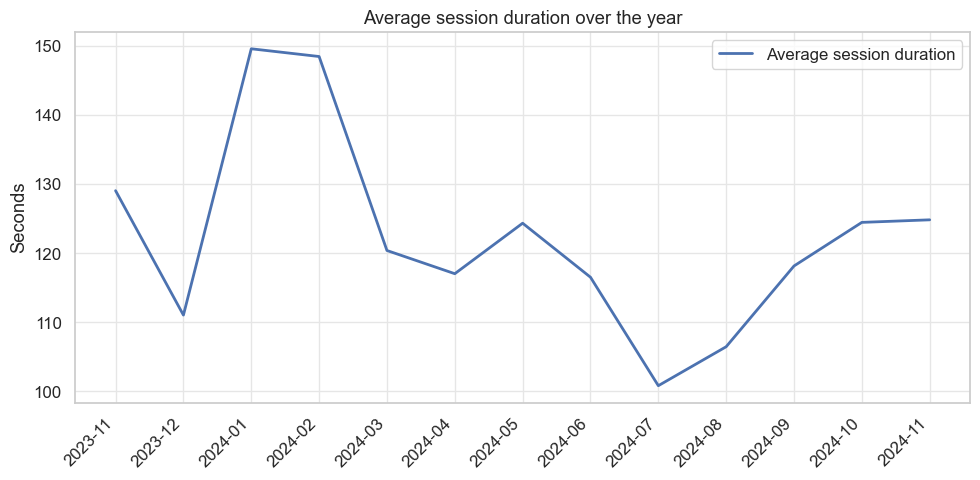

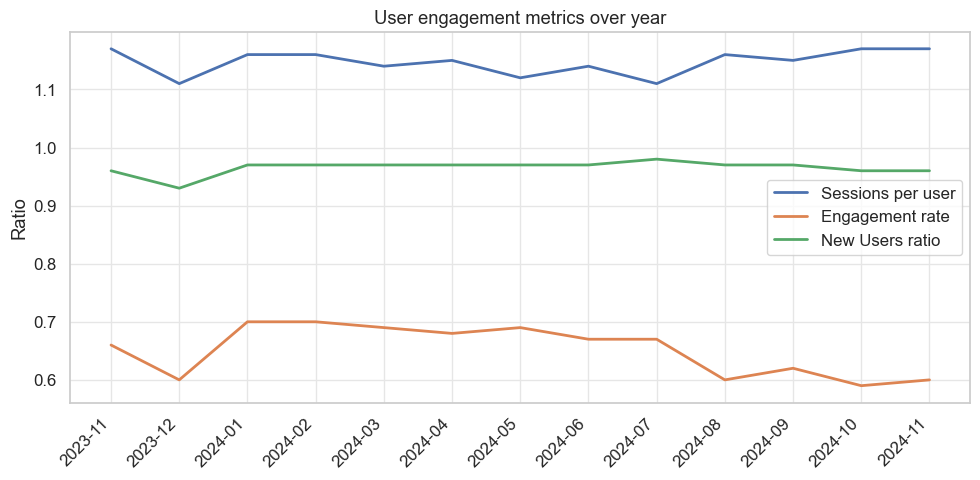

In [126]:
get_report_charts(df_komunalweb)

**Website moderniobec.cz**

In [127]:
df_moderniobec = df_websites[df_websites["website"] == "moderniobec.cz"]

In [128]:
get_report(df_moderniobec)

Average per month:
  active_users: 15541.85
  new_users: 13861.62
  sessions_per_user: 1.23
  average_session_duration: 147.34
  engagement_rate: 0.6
  new_users_ratio: 0.89

Total per year:
  active_users: 202044
  new_users: 180201


website year_month  year  month  active_users  new_users  \
115  moderniobec.cz    2024-01  2024      1         19088      16828   
116  moderniobec.cz    2024-02  2024      2         17530      15550   
113  moderniobec.cz    2023-11  2023     11         17307      15307   

     sessions  sessions_per_user  screen_page_views  engaged_sessions  \
115     23544               1.23                631             14705   
116     21770               1.24               1353             12942   
113     21864               1.26                628             13541   

     average_session_duration  engagement_rate  new_users_ratio  
115                    147.48             0.62             0.88  
116                    152.04             0.59             0.89  
113                    152.06             0.62             0.88

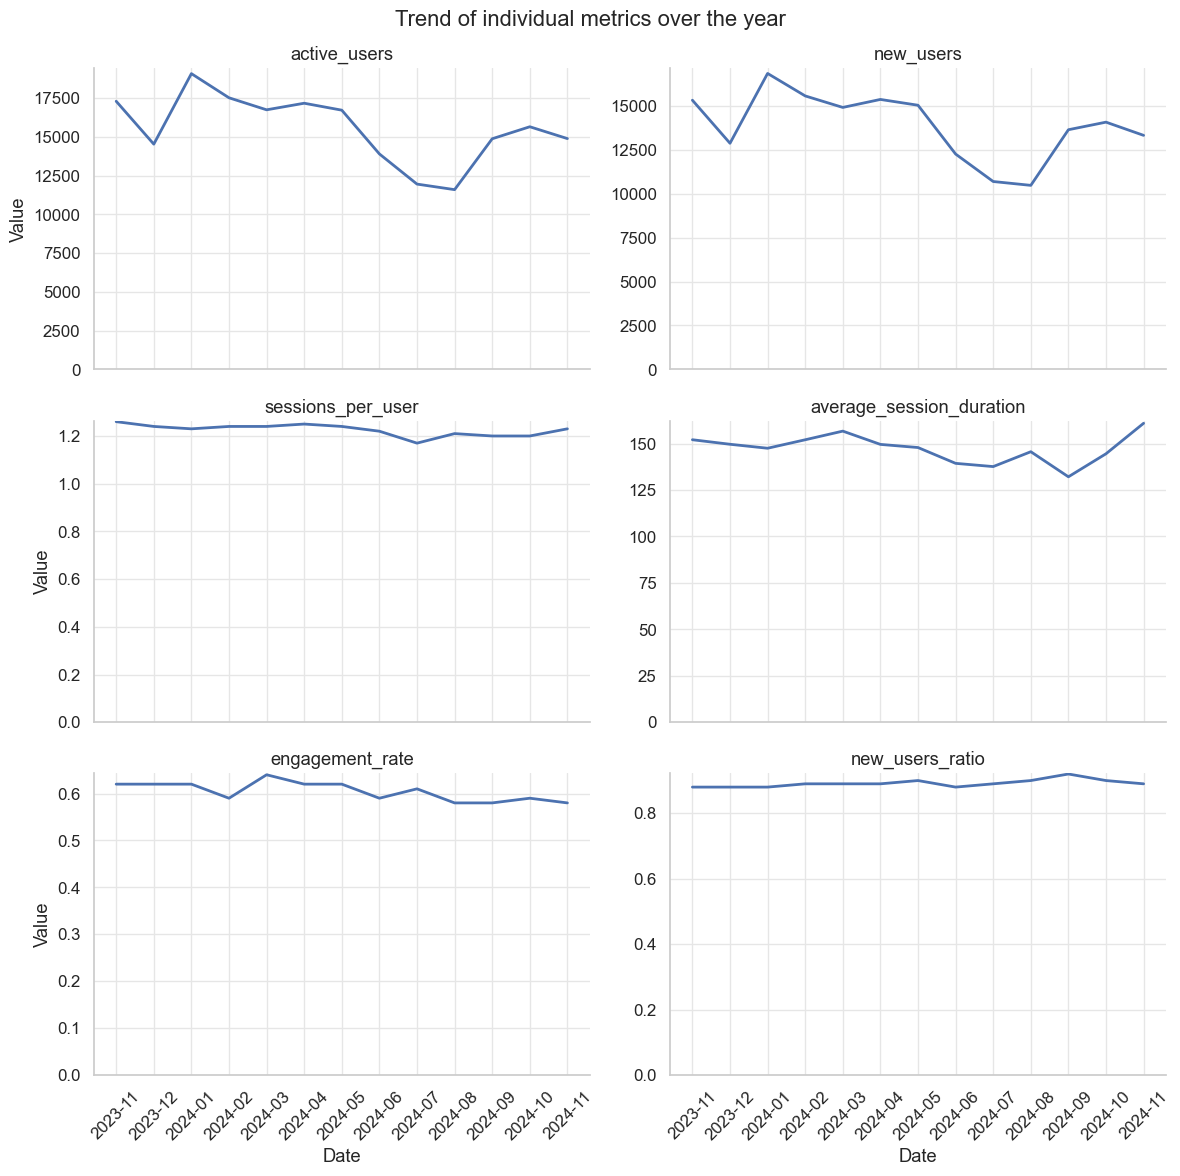

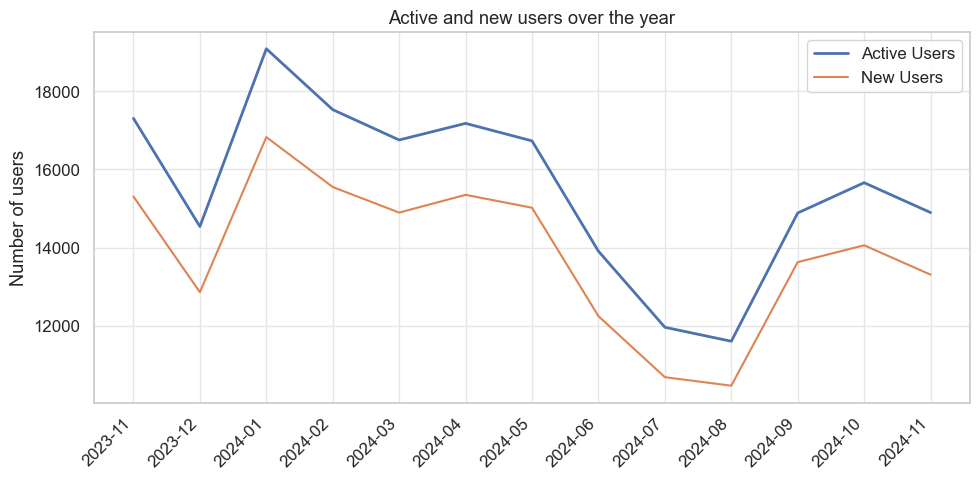

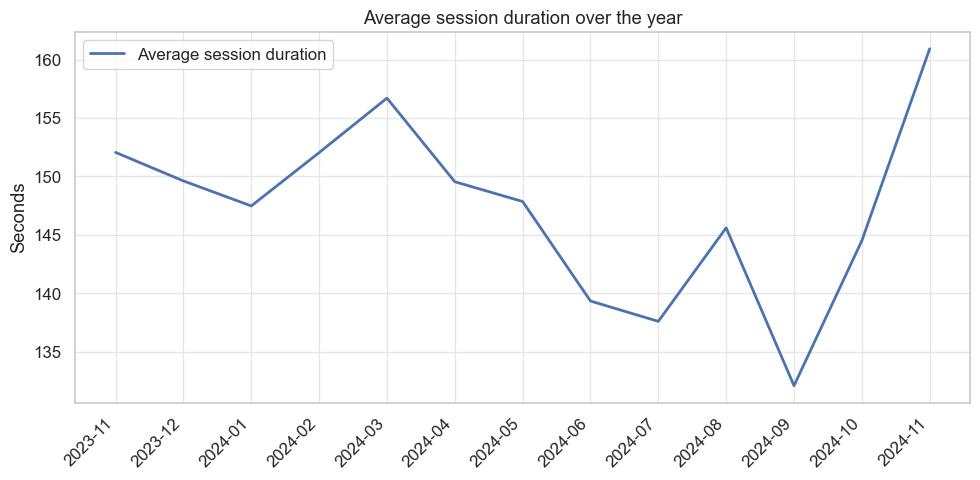

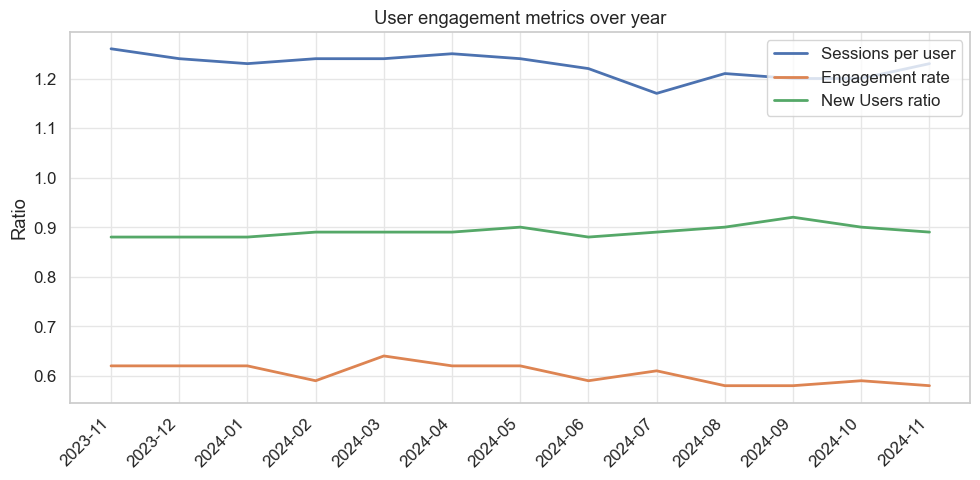

In [129]:
get_report_charts(df_moderniobec)

**Website naschov.cz**

In [130]:
df_naschov = df_websites[df_websites["website"] == "naschov.cz"]

In [131]:
get_report(df_naschov)

Average per month:
  active_users: 13474.31
  new_users: 12093.62
  sessions_per_user: 1.26
  average_session_duration: 141.23
  engagement_rate: 0.61
  new_users_ratio: 0.9

Total per year:
  active_users: 175166
  new_users: 157217


website year_month  year  month  active_users  new_users  sessions  \
128  naschov.cz    2024-01  2024      1         16761      15025     21636   
130  naschov.cz    2024-03  2024      3         16605      14636     21518   
131  naschov.cz    2024-04  2024      4         16357      14717     22052   

     sessions_per_user  screen_page_views  engaged_sessions  \
128               1.29                568             13713   
130               1.30                953             14052   
131               1.35                909             13801   

     average_session_duration  engagement_rate  new_users_ratio  
128                    145.87             0.63             0.90  
130                    156.88             0.65             0.88  
131                    154.93             0.63             0.90

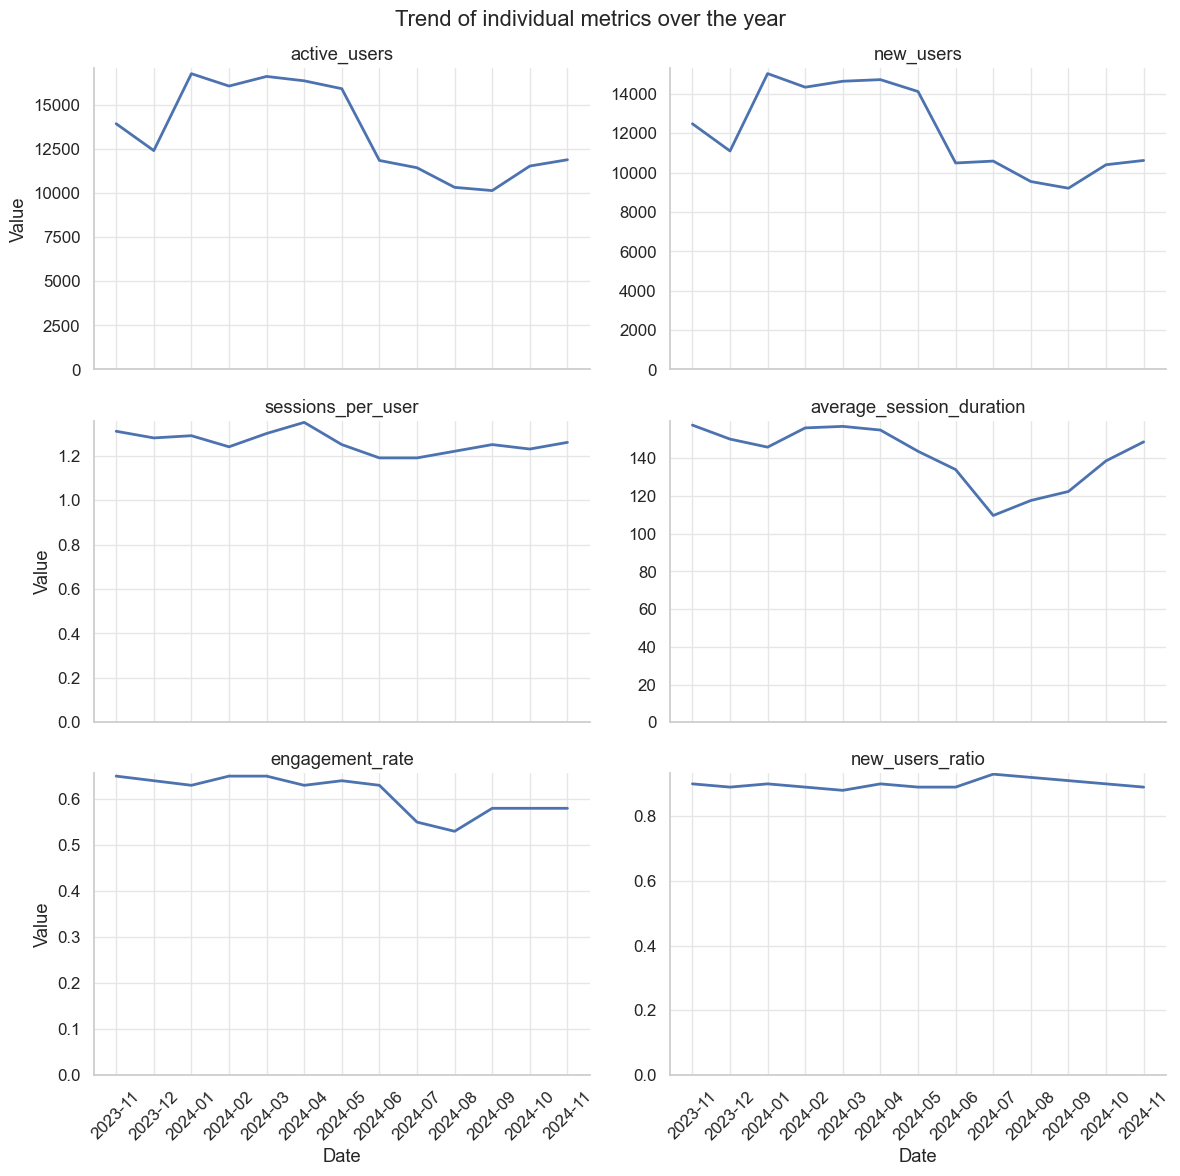

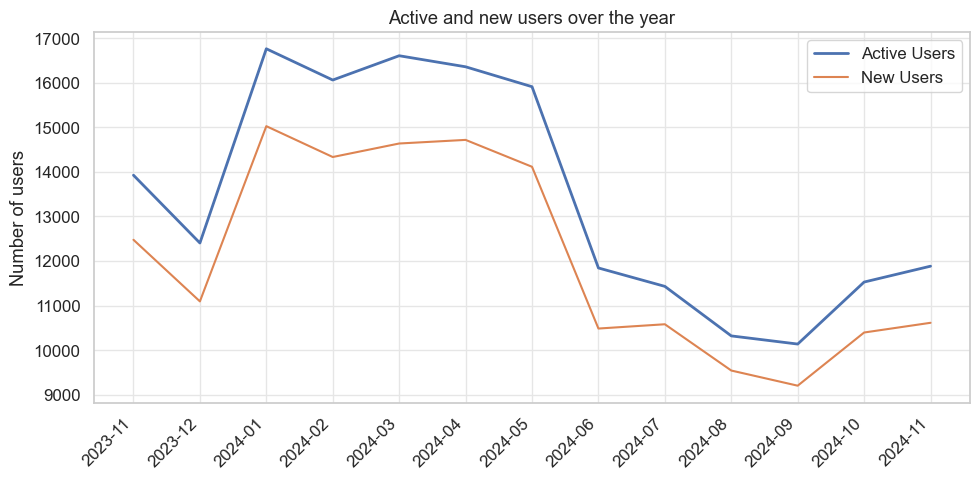

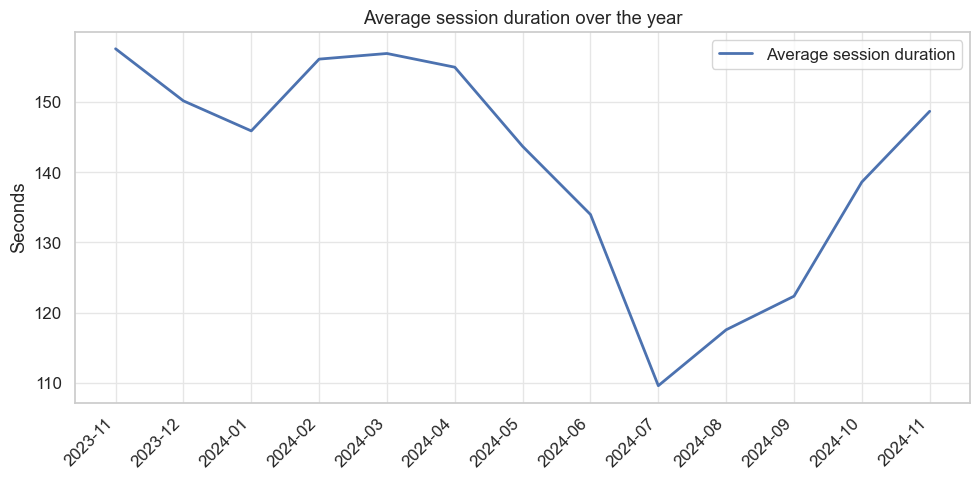

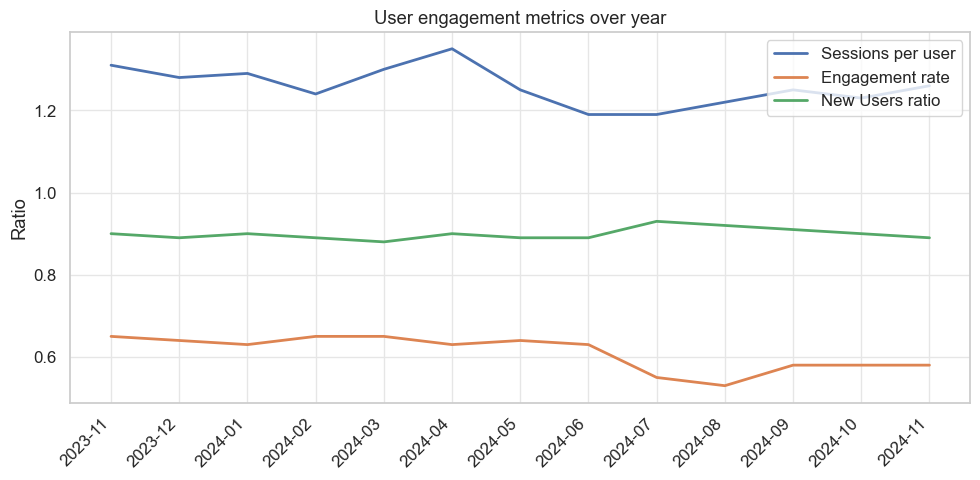

In [132]:
get_report_charts(df_naschov)

**Website odpady-online.cz**

In [133]:
df_odpady_online = df_websites[df_websites["website"] == "odpady-online.cz"]

In [134]:
get_report(df_odpady_online)

Average per month:
  active_users: 6249.38
  new_users: 5939.23
  sessions_per_user: 1.19
  average_session_duration: 126.62
  engagement_rate: 0.57
  new_users_ratio: 0.95

Total per year:
  active_users: 81242
  new_users: 77210


website year_month  year  month  active_users  new_users  \
166  odpady-online.cz    2024-01  2024      1          7592       7130   
168  odpady-online.cz    2024-03  2024      3          7560       7203   
167  odpady-online.cz    2024-02  2024      2          7338       6966   

     sessions  sessions_per_user  screen_page_views  engaged_sessions  \
166      8996               1.18                522              5482   
168      9117               1.21                531              5434   
167      8773               1.20                544              5306   

     average_session_duration  engagement_rate  new_users_ratio  
166                    149.24             0.61             0.94  
168                    133.11             0.60             0.95  
167                    142.54             0.60             0.95

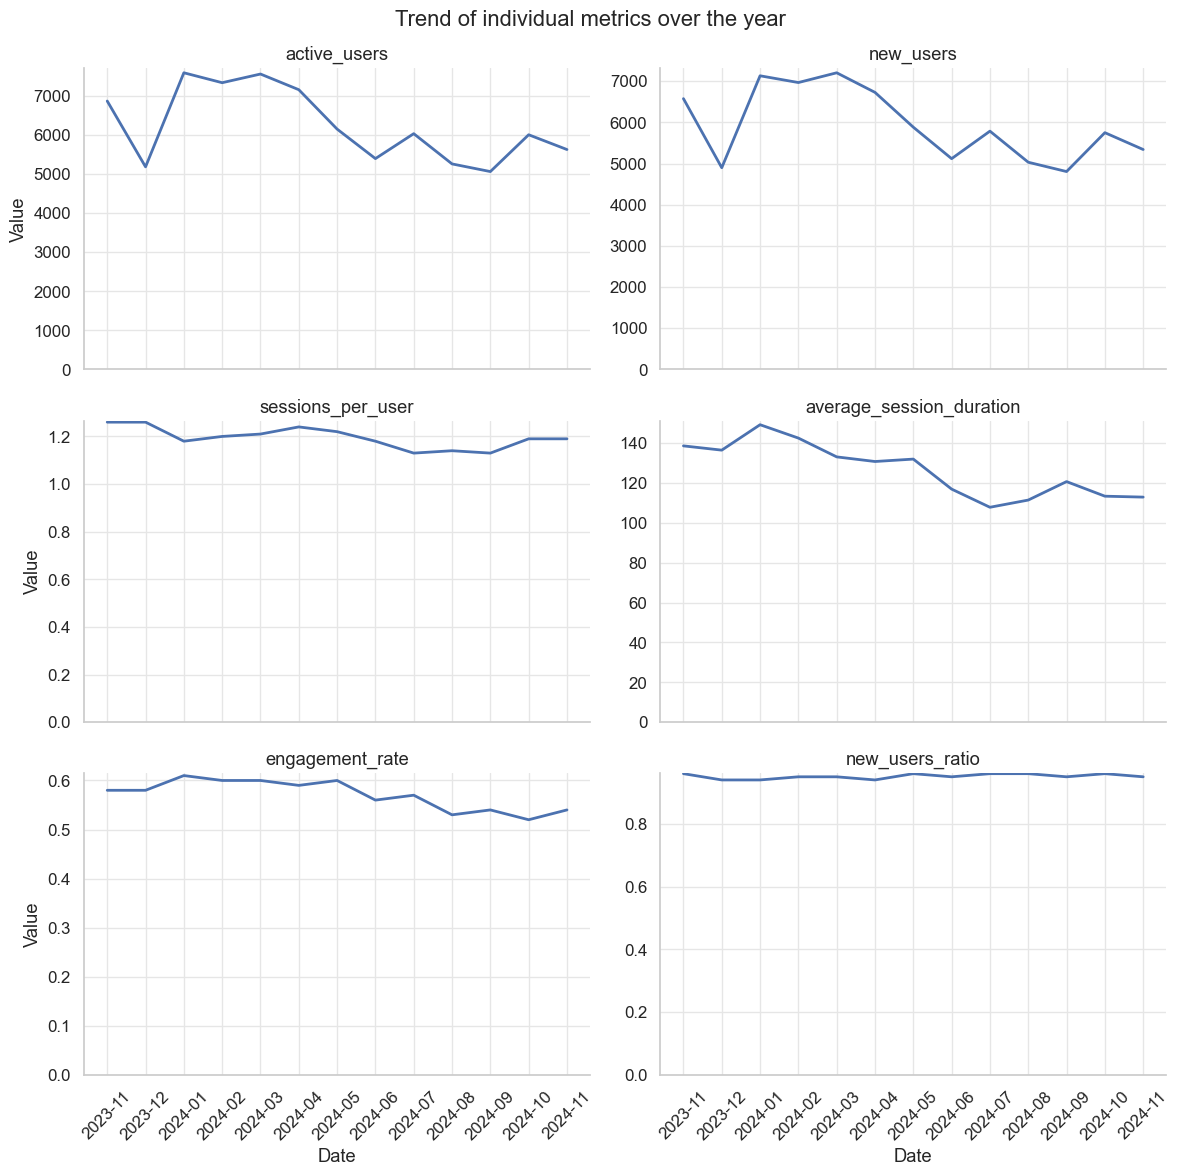

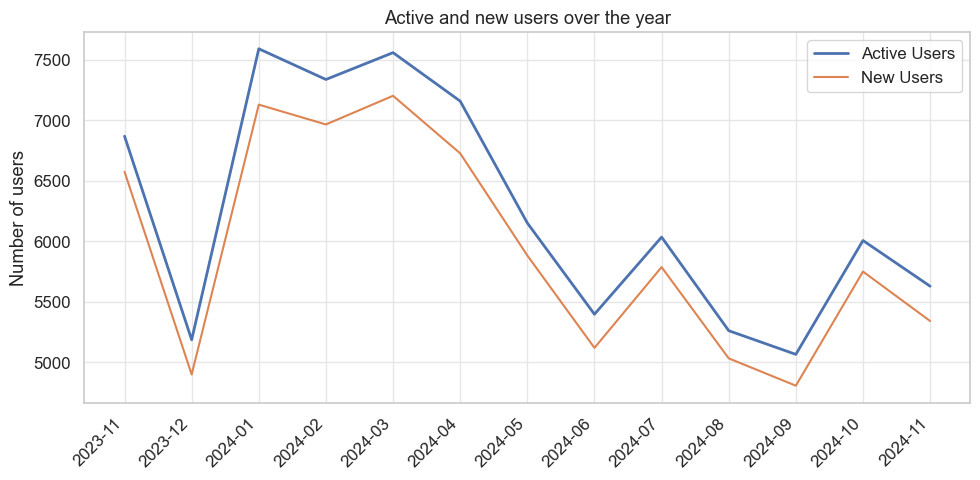

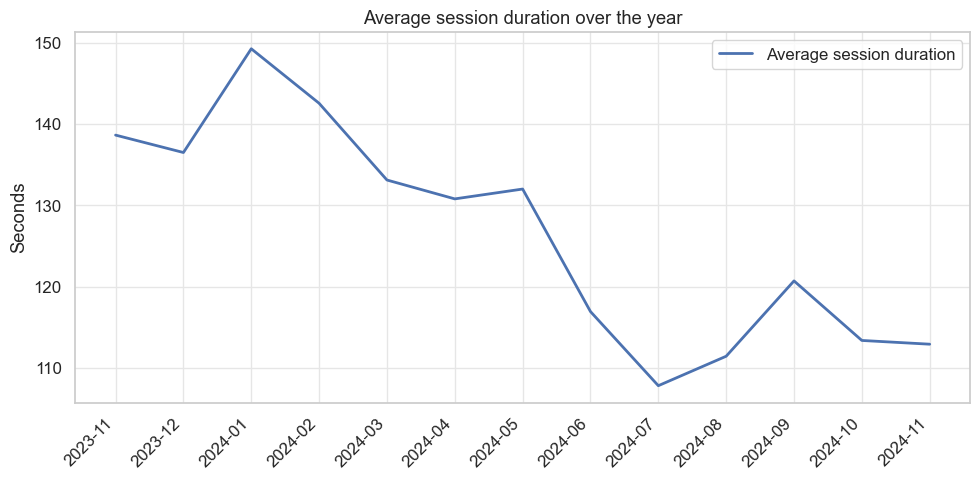

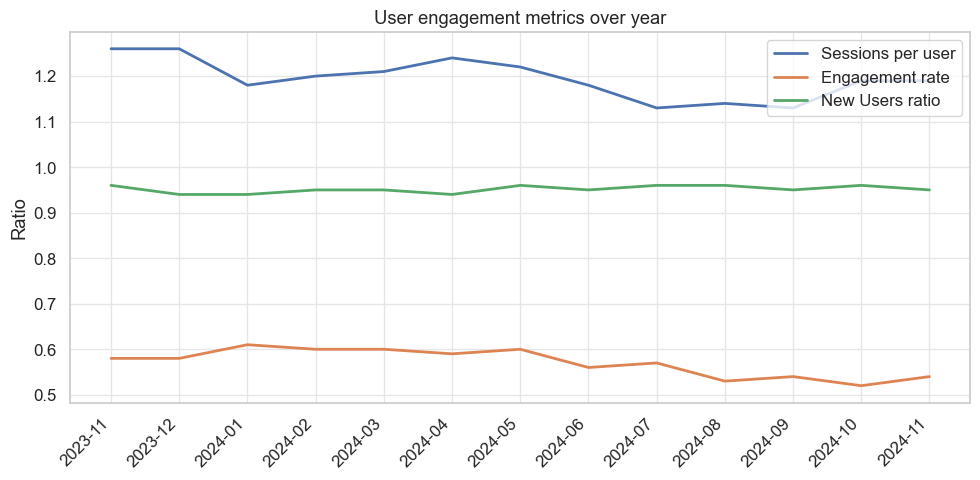

In [135]:
get_report_charts(df_odpady_online)

**Website vetweb.cz**

In [136]:
df_vetweb = df_websites[df_websites["website"] == "vetweb.cz"]

In [137]:
get_report(df_vetweb)

Average per month:
  active_users: 14559.08
  new_users: 13419.31
  sessions_per_user: 1.24
  average_session_duration: 133.07
  engagement_rate: 0.56
  new_users_ratio: 0.92

Total per year:
  active_users: 189268
  new_users: 174451


website year_month  year  month  active_users  new_users  sessions  \
224  vetweb.cz    2024-05  2024      5         18361      16889     22086   
220  vetweb.cz    2024-01  2024      1         18042      16779     21715   
223  vetweb.cz    2024-04  2024      4         16182      14730     20429   

     sessions_per_user  screen_page_views  engaged_sessions  \
224               1.20               6507             13083   
220               1.20               3066             12658   
223               1.26                534             12206   

     average_session_duration  engagement_rate  new_users_ratio  
224                    131.13             0.59             0.92  
220                    141.28             0.58             0.93  
223                    145.75             0.60             0.91

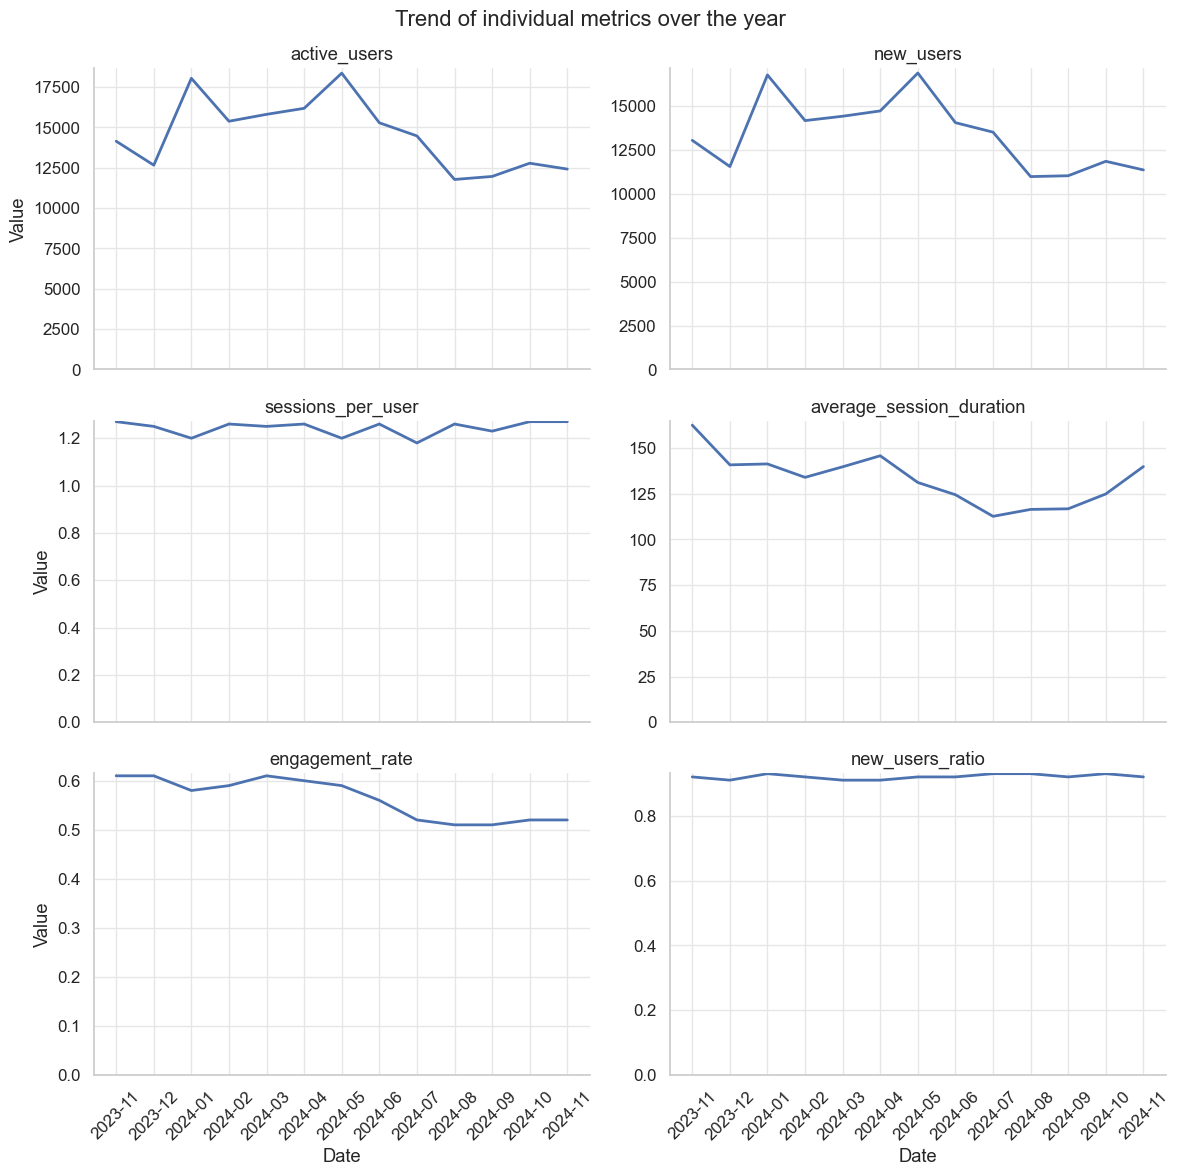

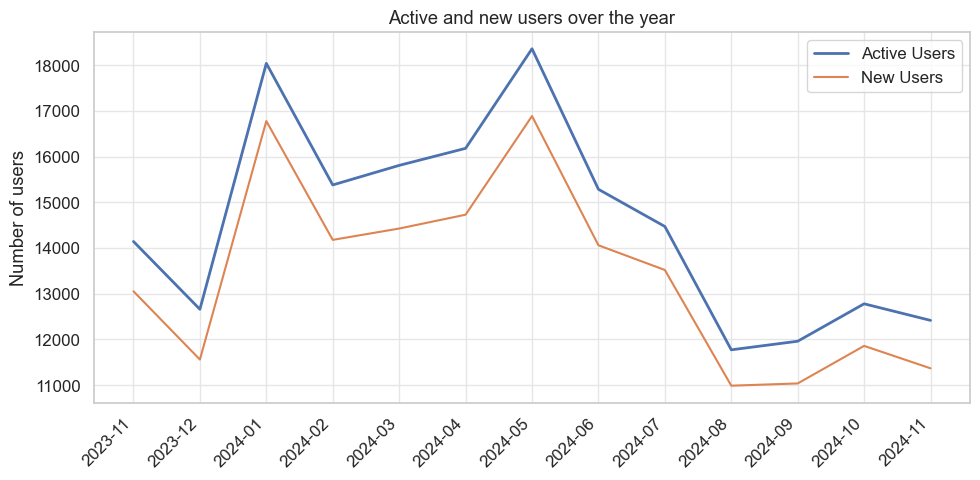

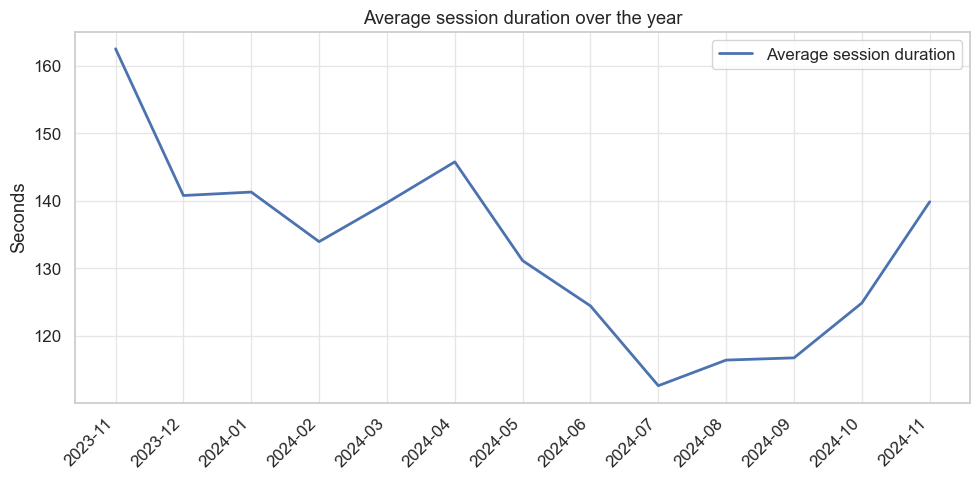

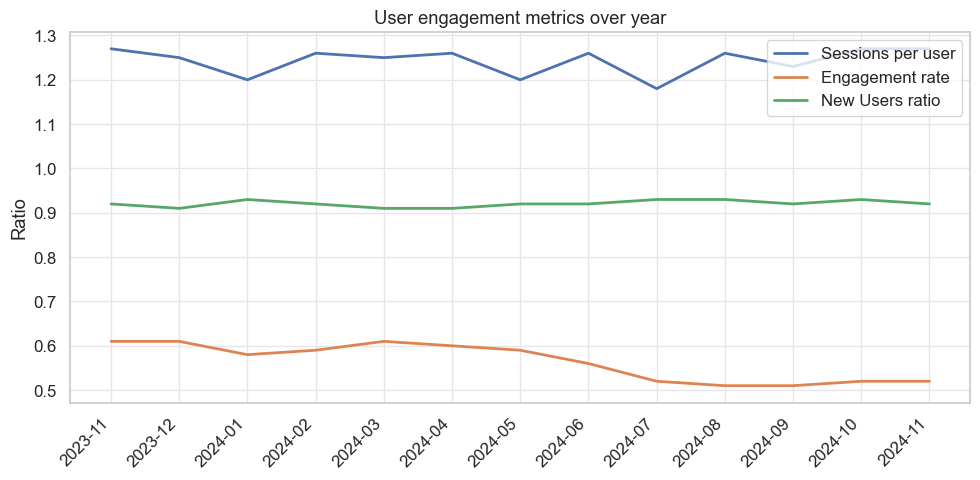

In [138]:
get_report_charts(df_vetweb)

**Website tvzemedelec.cz**

In [139]:
df_tvzemedelec = df_websites[df_websites["website"] == "tvzemedelec.cz"]

In [140]:
get_report(df_tvzemedelec)

Average per month:
  active_users: 94.23
  new_users: 86.54
  sessions_per_user: 1.79
  average_session_duration: 232.43
  engagement_rate: 0.55
  new_users_ratio: 0.89

Total per year:
  active_users: 1225
  new_users: 1125


website year_month  year  month  active_users  new_users  \
207  tvzemedelec.cz    2024-03  2024      3           411        380   
206  tvzemedelec.cz    2024-02  2024      2           278        265   
208  tvzemedelec.cz    2024-04  2024      4           158        145   

     sessions  sessions_per_user  screen_page_views  engaged_sessions  \
207       593               1.44                723               318   
206       415               1.49                515               208   
208       259               1.64                306               114   

     average_session_duration  engagement_rate  new_users_ratio  
207                    127.70             0.54             0.92  
206                    153.68             0.50             0.95  
208                    118.94             0.44             0.92

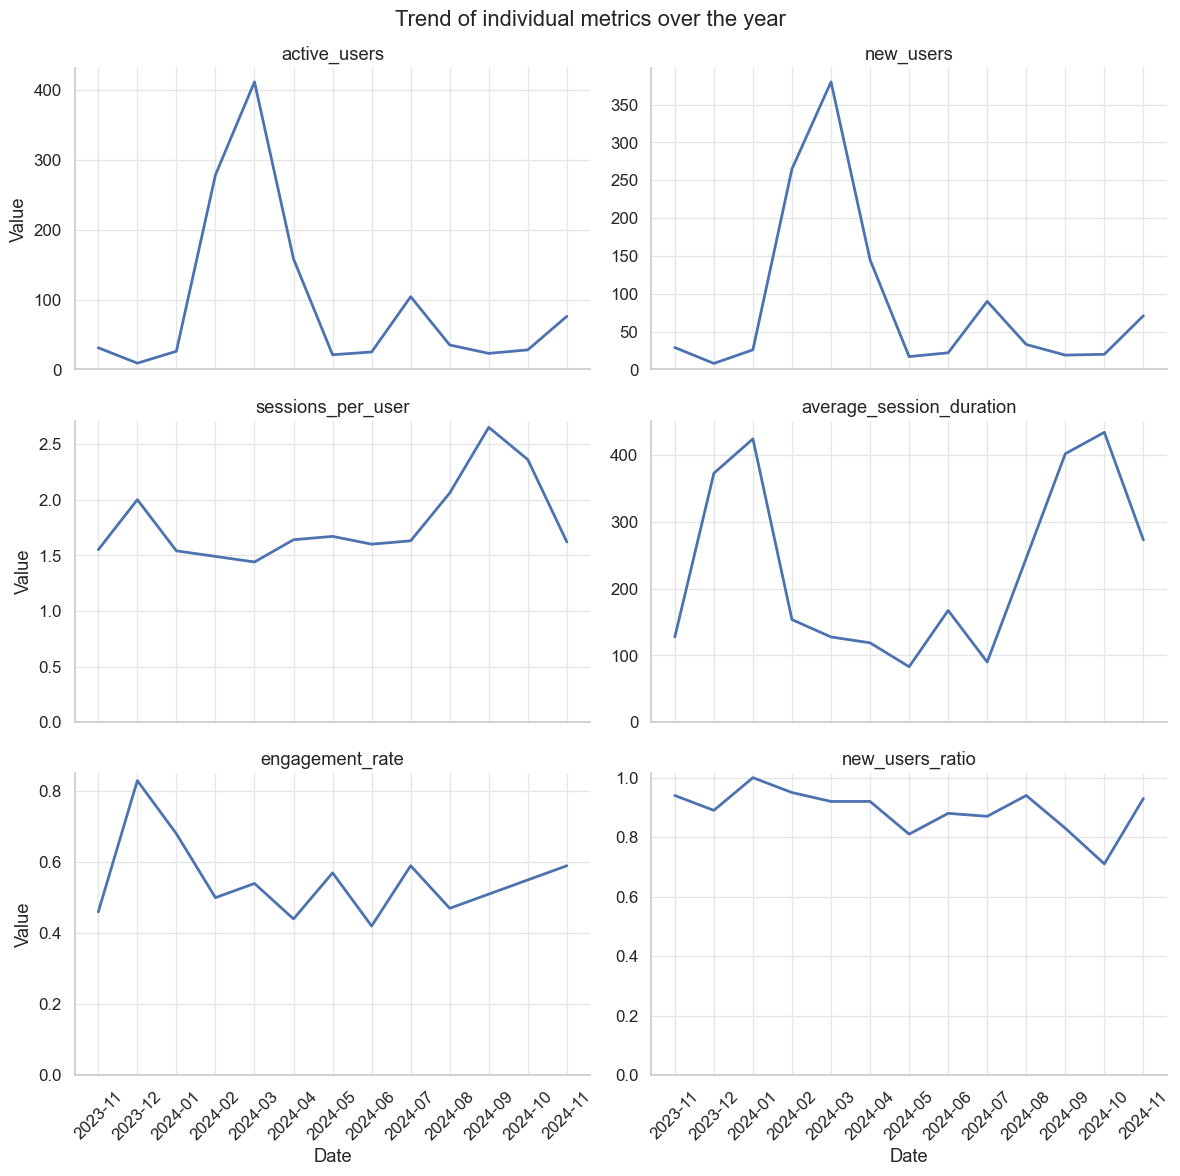

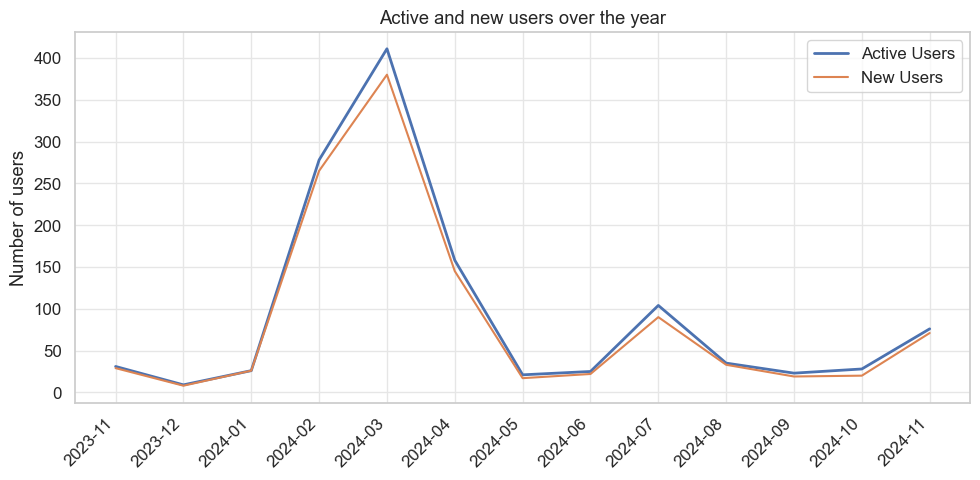

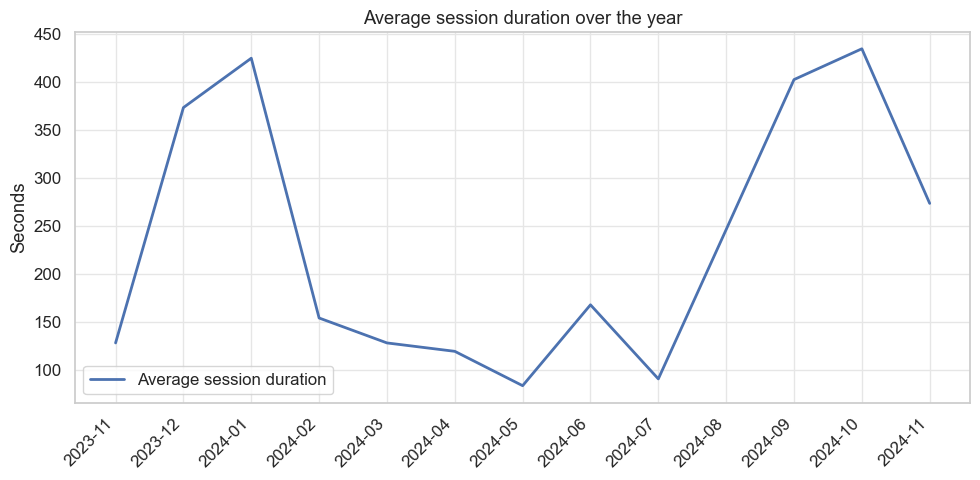

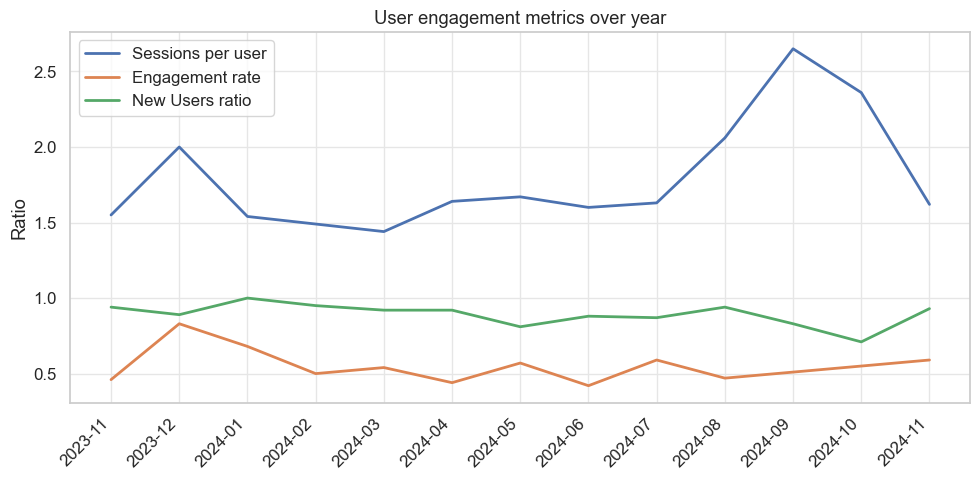

In [141]:
get_report_charts(df_tvzemedelec)

**Website zahradaweb.cz**

In [142]:
df_zahradaweb = df_websites[df_websites["website"] == "zahradaweb.cz"]

In [143]:
get_report(df_zahradaweb)

Average per month:
  active_users: 14048.15
  new_users: 13441.08
  sessions_per_user: 1.13
  average_session_duration: 120.27
  engagement_rate: 0.63
  new_users_ratio: 0.96

Total per year:
  active_users: 182626
  new_users: 174734


website year_month  year  month  active_users  new_users  sessions  \
244  zahradaweb.cz    2024-05  2024      5         24220      23379     27118   
243  zahradaweb.cz    2024-04  2024      4         21960      20994     24406   
245  zahradaweb.cz    2024-06  2024      6         19625      18780     22253   

     sessions_per_user  screen_page_views  engaged_sessions  \
244               1.12                686             18601   
243               1.11                445             16956   
245               1.13                350             14394   

     average_session_duration  engagement_rate  new_users_ratio  
244                    119.04             0.69             0.97  
243                    125.40             0.69             0.96  
245                    106.91             0.65             0.96

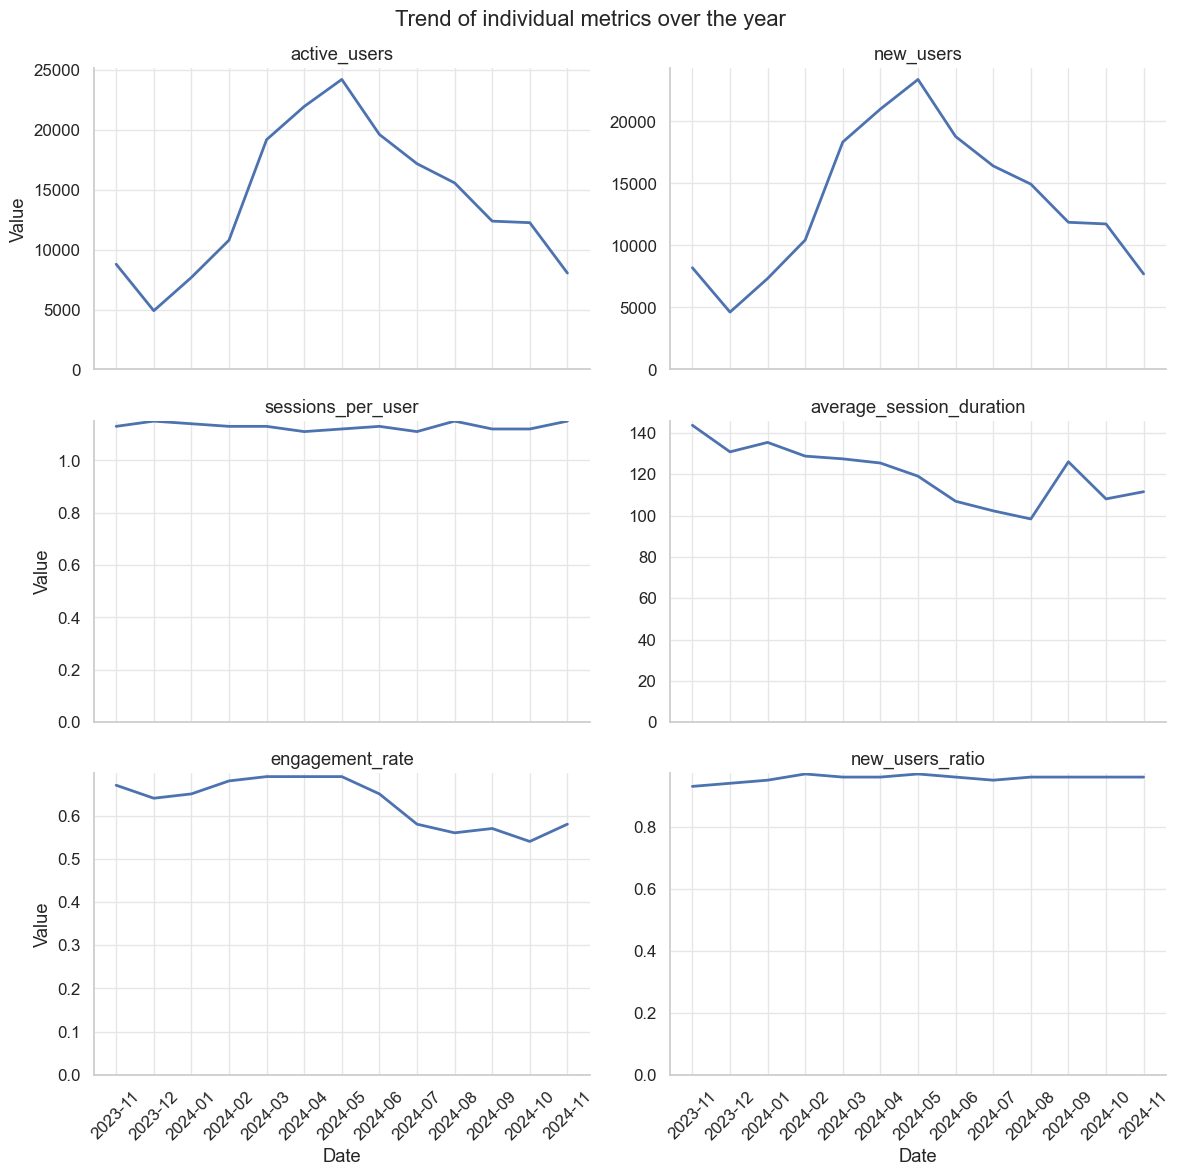

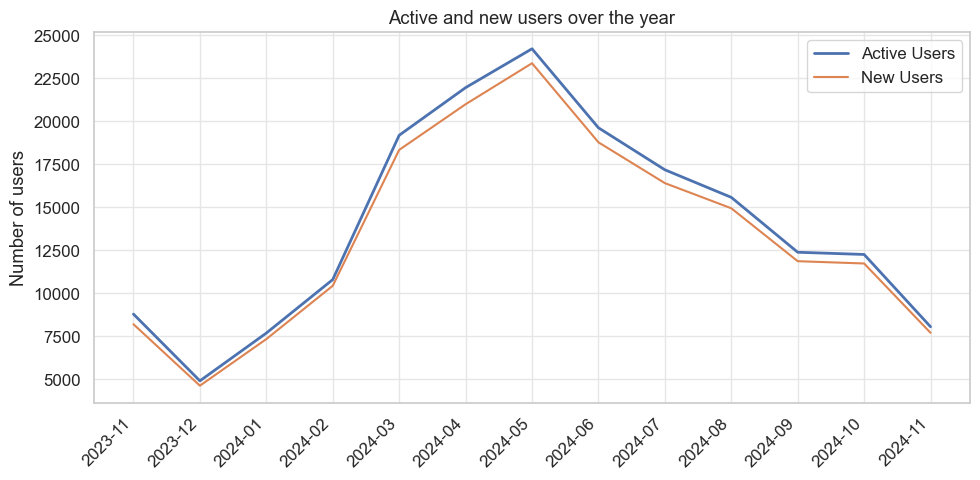

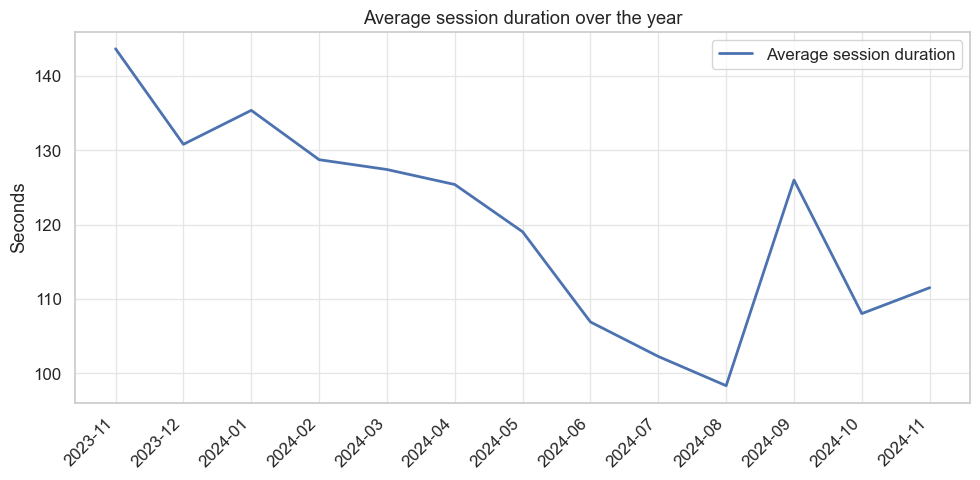

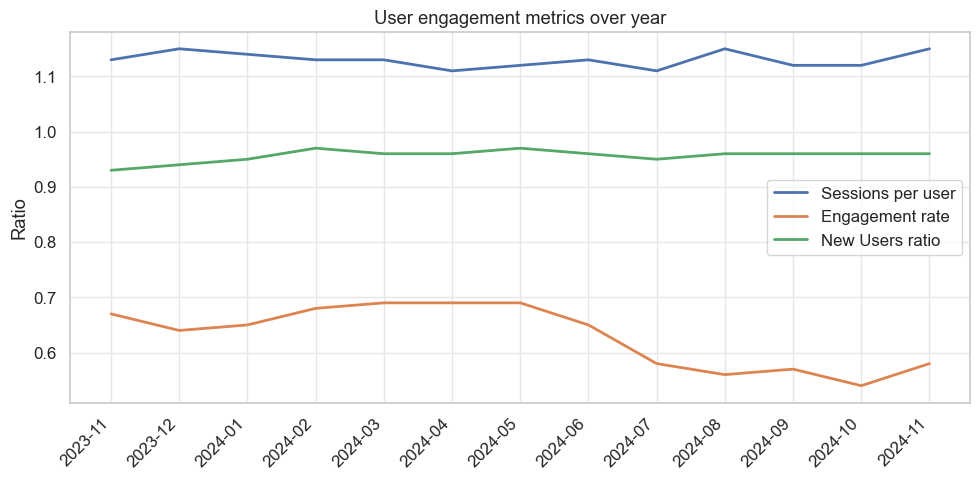

In [144]:
get_report_charts(df_zahradaweb)

**Comparison of websites traffic**

In [145]:
sns.set_theme(
    style="whitegrid",
    palette="bright",
    font_scale=1.1,
    rc={"grid.color": "#e6e6e6"},
)

In [146]:
def comparison_sum_mean(df, metric):
    """Functions for creating charts comparing websites. Separate comparison for each metric.
    This function is used for metrics where the average value and sum of values is calculated."""

    metric_label = re.sub(r"_", " ", metric).title()

    # Line charts for websites
    plt.figure(figsize=(12,6))
    sns.lineplot(data=df, x="year_month", y=metric, hue="website", linewidth=3)
    plt.title(f"{metric_label} over time")
    plt.xticks(rotation=45, ha="right")
    plt.xlabel("")
    plt.ylabel(metric_label)
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.)
    plt.tight_layout()
    plt.show()

    # Heatmap for websites
    df_pivot = df.pivot(index="website", columns="year_month", values=metric)
    plt.figure(figsize=(12, 6))
    sns.heatmap(df_pivot, cmap="viridis", annot=False, cbar_kws={"label": metric_label})
    plt.title(f"{metric_label} over time")
    plt.xlabel("")
    plt.ylabel("")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    # Calculation of average and sum
    df_grouped_mean = df.groupby("website")[metric].mean().sort_values(ascending=False).reset_index()
    df_grouped_sum = df.groupby("website")[metric].sum().sort_values(ascending=False).reset_index()

    # Create a bar chart for average and sum
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    sns.barplot(data=df_grouped_mean, x=metric, y="website", color="lightgreen", ax=axes[0])
    axes[0].set_title(f"Average per month: {metric_label}")
    axes[0].set_xlabel(metric_label)
    axes[0].set_ylabel("")
    axes[0].tick_params(axis="x", rotation=45)

    sns.barplot(data=df_grouped_sum, x=metric, y="website", color="skyblue", ax=axes[1])
    axes[1].set_title(f"Total amount: {metric_label}")
    axes[1].set_xlabel(metric_label)
    axes[1].set_ylabel("")
    axes[1].tick_params(axis="x", rotation=45)

    plt.tight_layout()
    plt.show()

In [147]:
def comparison_mean(df, metric):
    """Functions for creating charts comparing websites. Separate comparison for each metric.
    This function is used for metrics where only the average value is calculated."""

    metric_label = re.sub(r"_", " ", metric).title()

    # Line charts for websites
    plt.figure(figsize=(12,6))
    sns.lineplot(data=df, x="year_month", y=metric, hue="website", linewidth=3)
    plt.title(f"{metric_label} over time")
    plt.xticks(rotation=45, ha="right")
    plt.xlabel("")
    plt.ylabel(metric_label)
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.)
    plt.tight_layout()
    plt.show()

    # Heatmap for websites
    df_pivot = df.pivot(index="website", columns="year_month", values=metric)
    plt.figure(figsize=(12, 6))
    sns.heatmap(df_pivot, cmap="viridis", annot=False, cbar_kws={"label": metric_label})
    plt.title(f"{metric_label} over time")
    plt.xlabel("")
    plt.ylabel("")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    # Calculation of average
    df_grouped_mean = df.groupby("website")[metric].mean().sort_values(ascending=False).reset_index()

    # Bar chart for average value
    plt.figure(figsize=(12, 6))
    sns.barplot(data=df_grouped_mean, x=metric, y="website", color="lightgreen")
    plt.title(f"Average per month: {metric_label}")
    plt.xlabel(metric_label)
    plt.ylabel("")
    plt.tight_layout()
    plt.show()

**Active users**

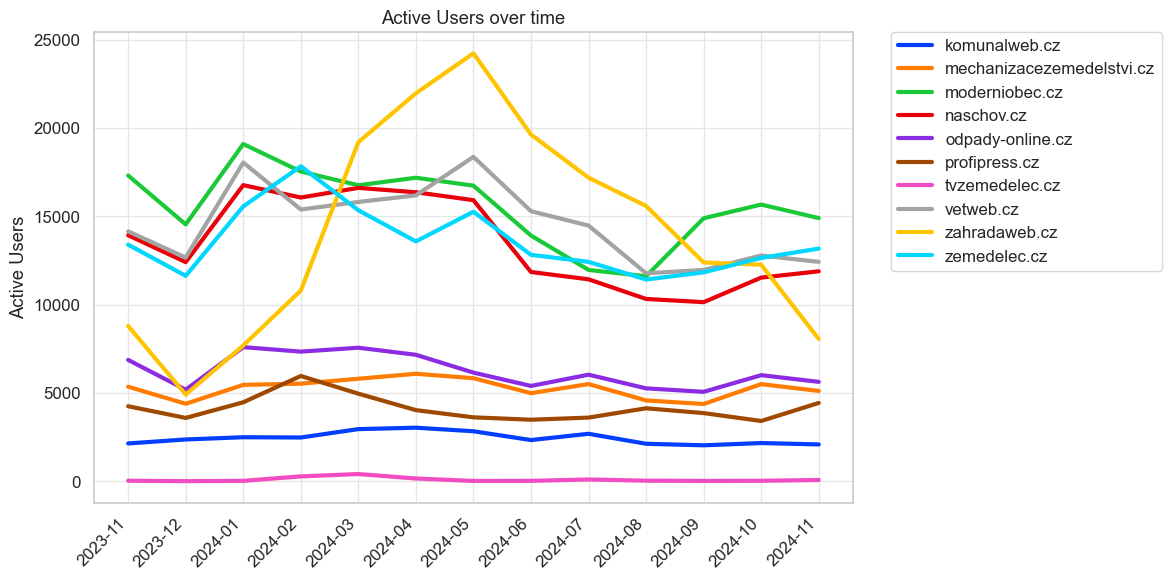

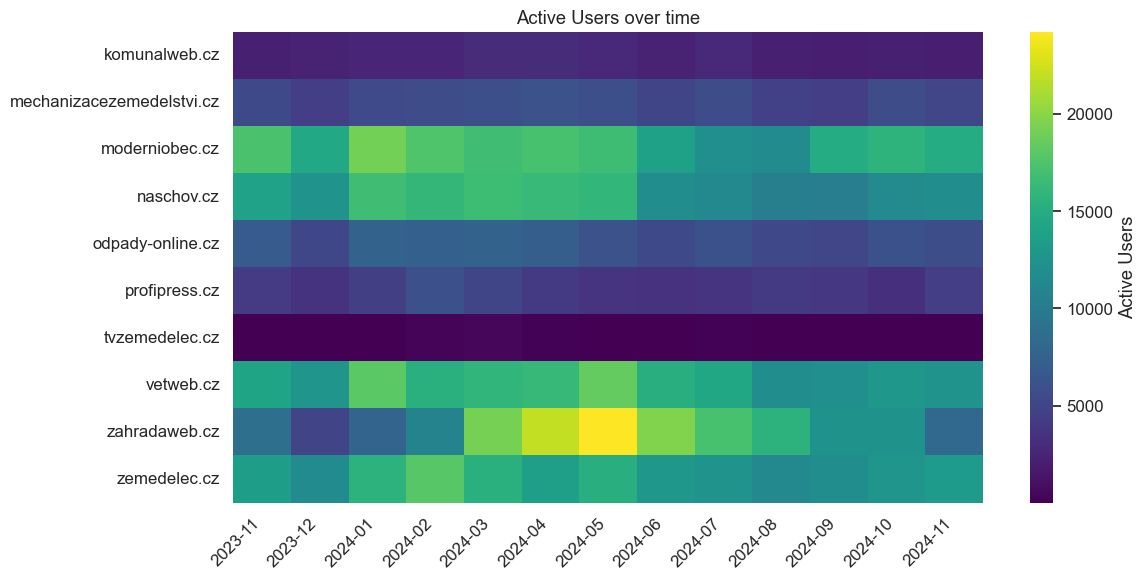

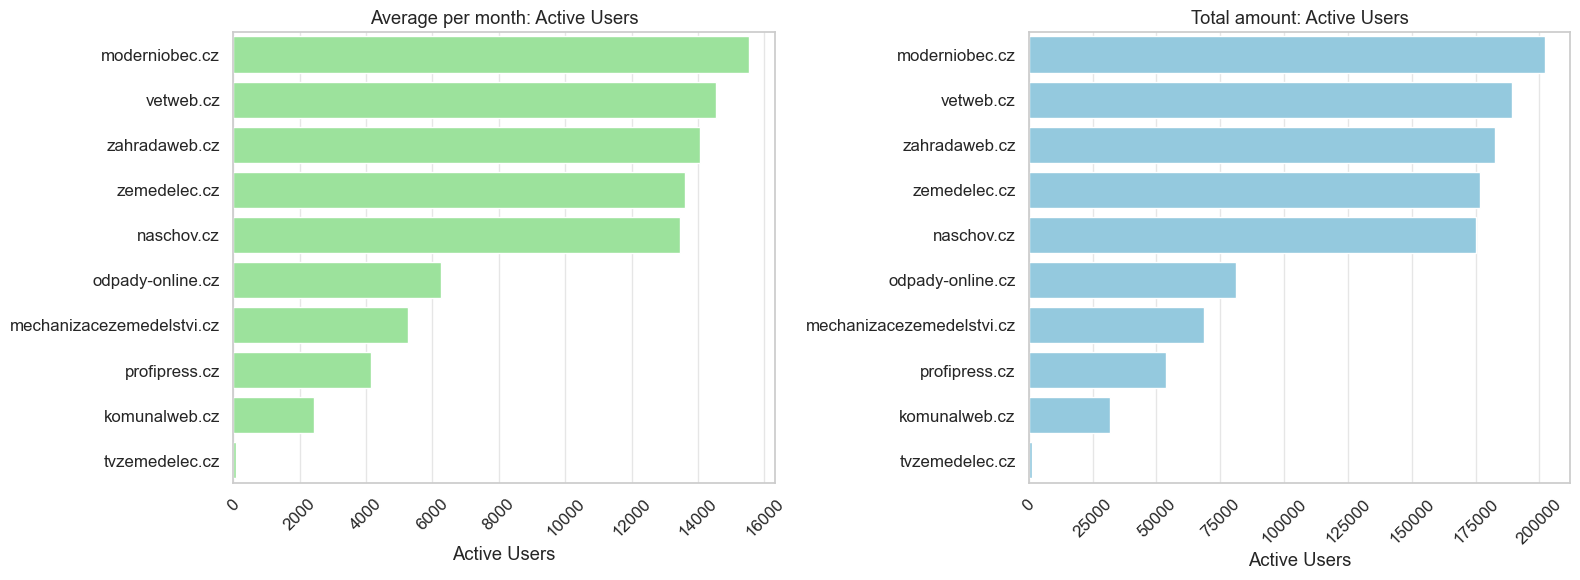

In [148]:
comparison_sum_mean(df_websites, metric="active_users")

**New users**

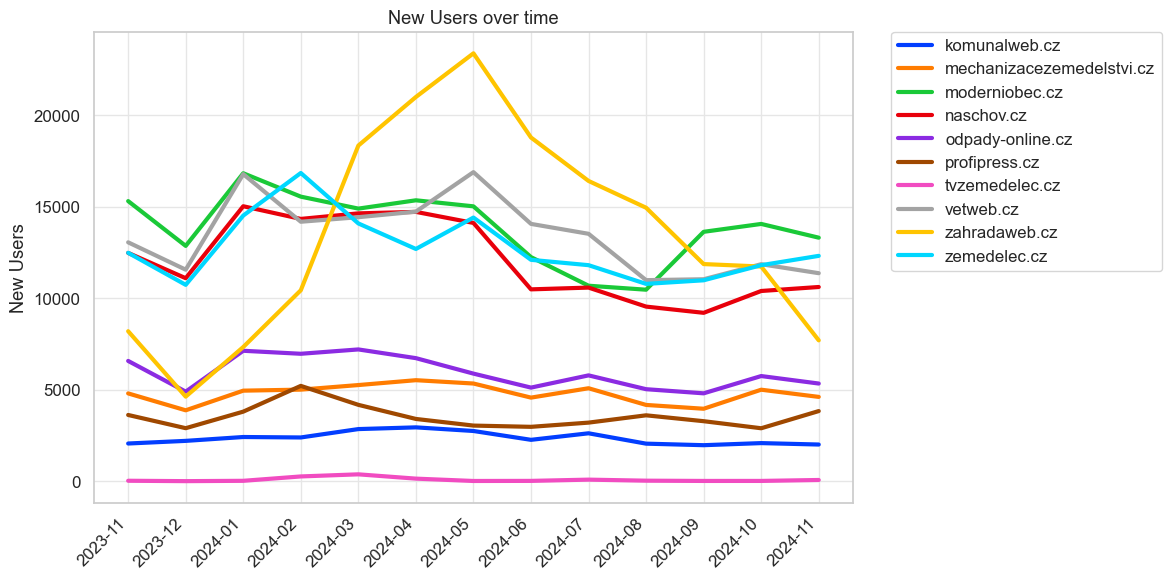

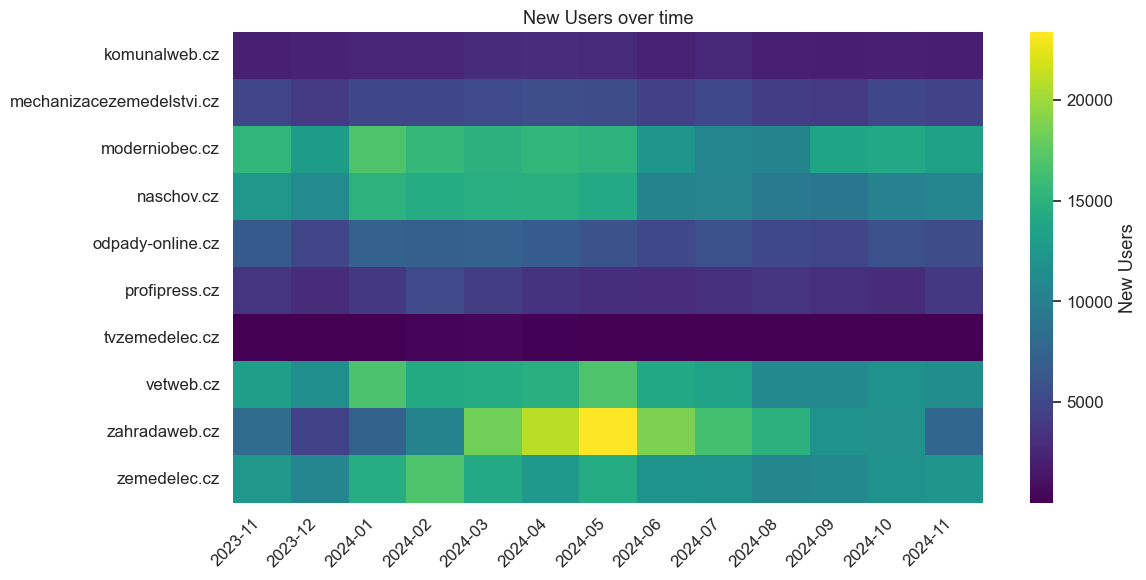

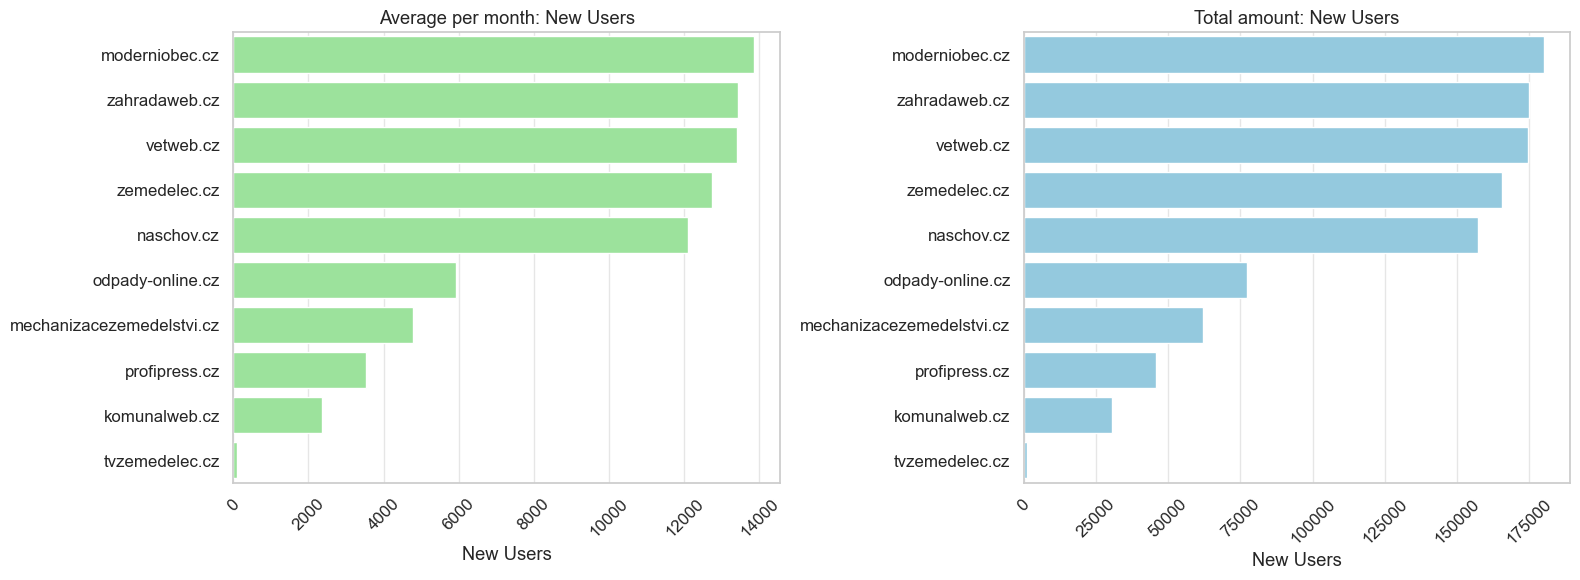

In [149]:
comparison_sum_mean(df_websites, "new_users")

**Sessions per user**

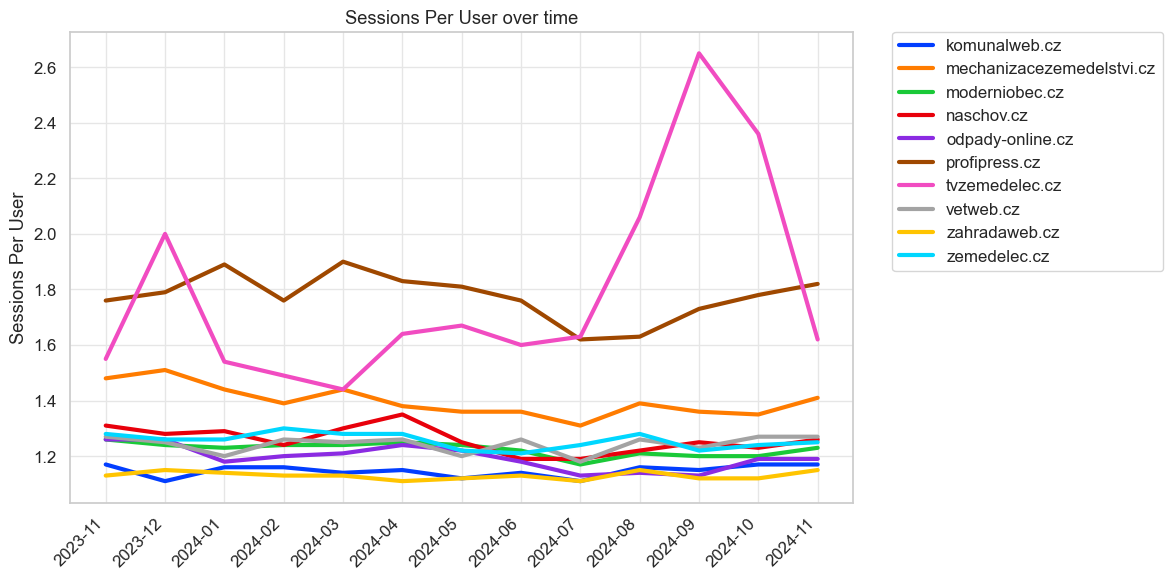

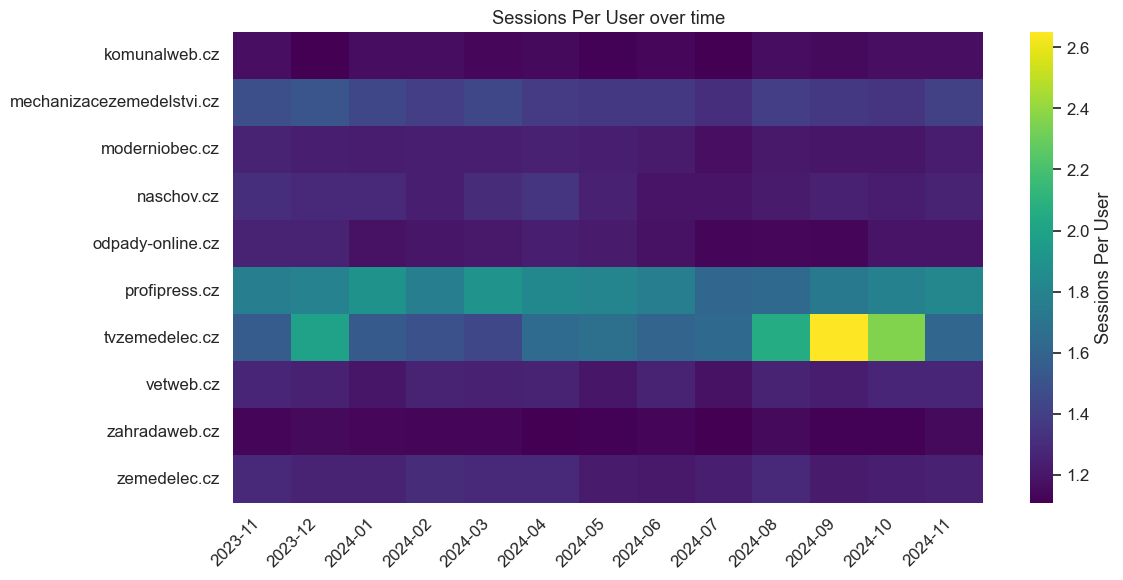

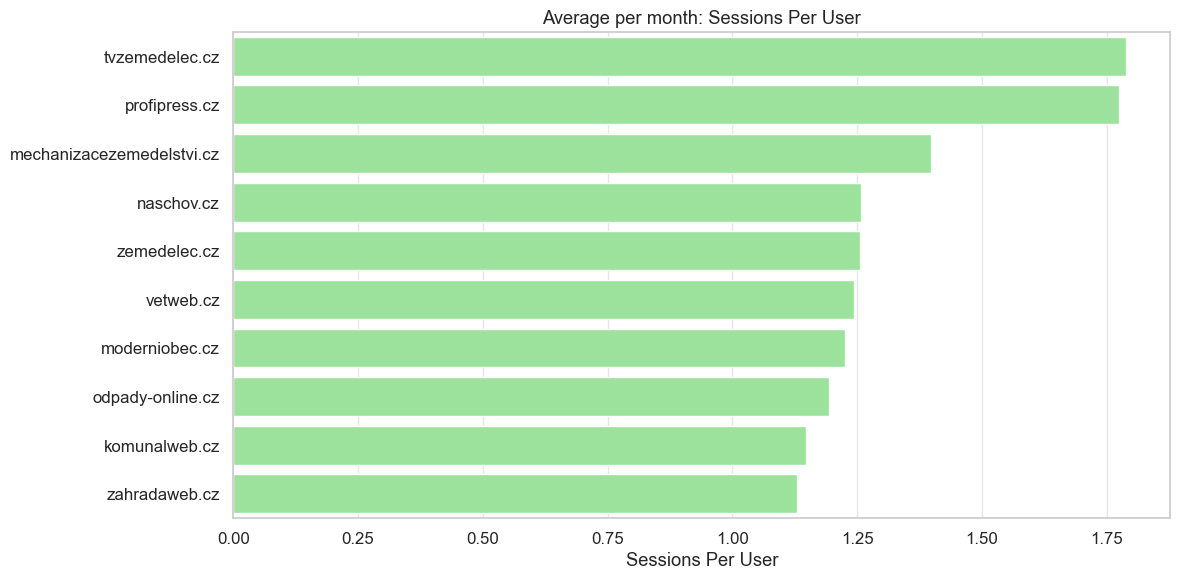

In [150]:
comparison_mean(df_websites, "sessions_per_user")

**Average session duration**

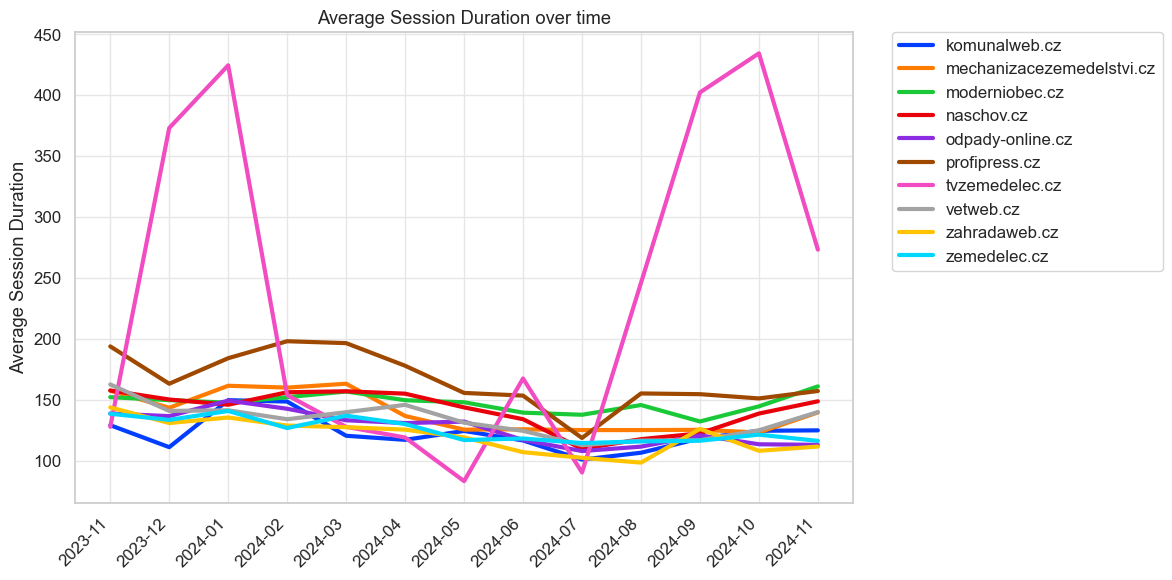

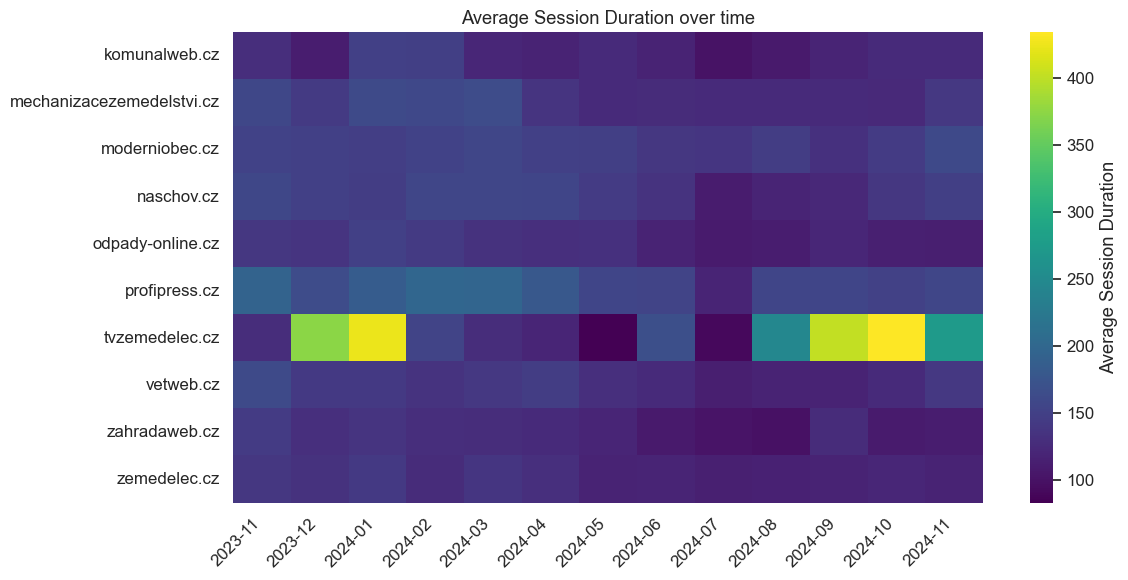

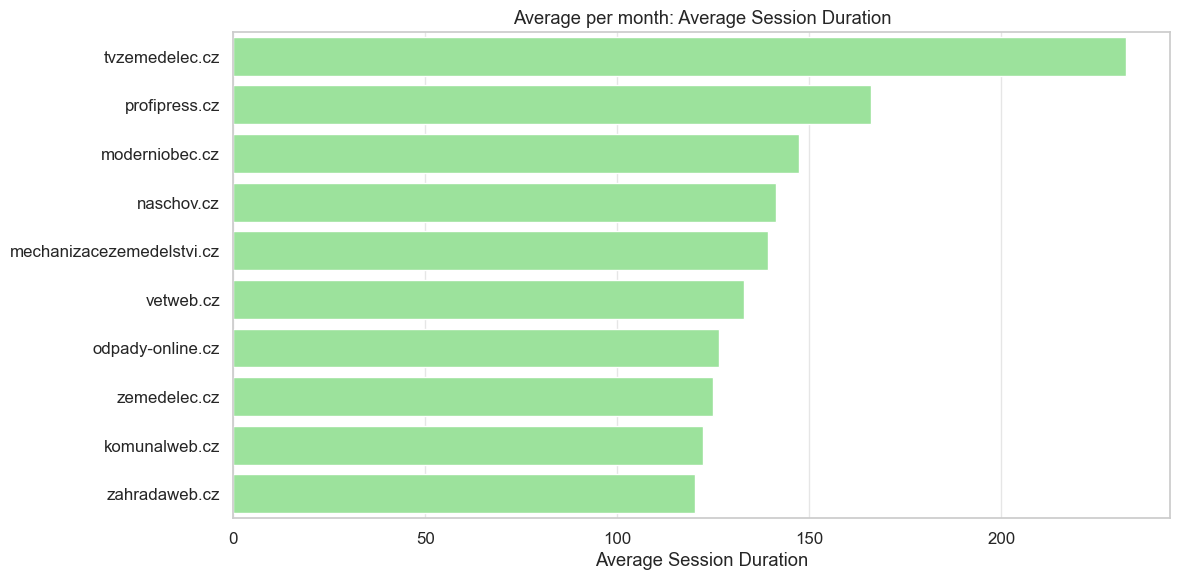

In [151]:
comparison_mean(df_websites, "average_session_duration")

**Engagement rate**

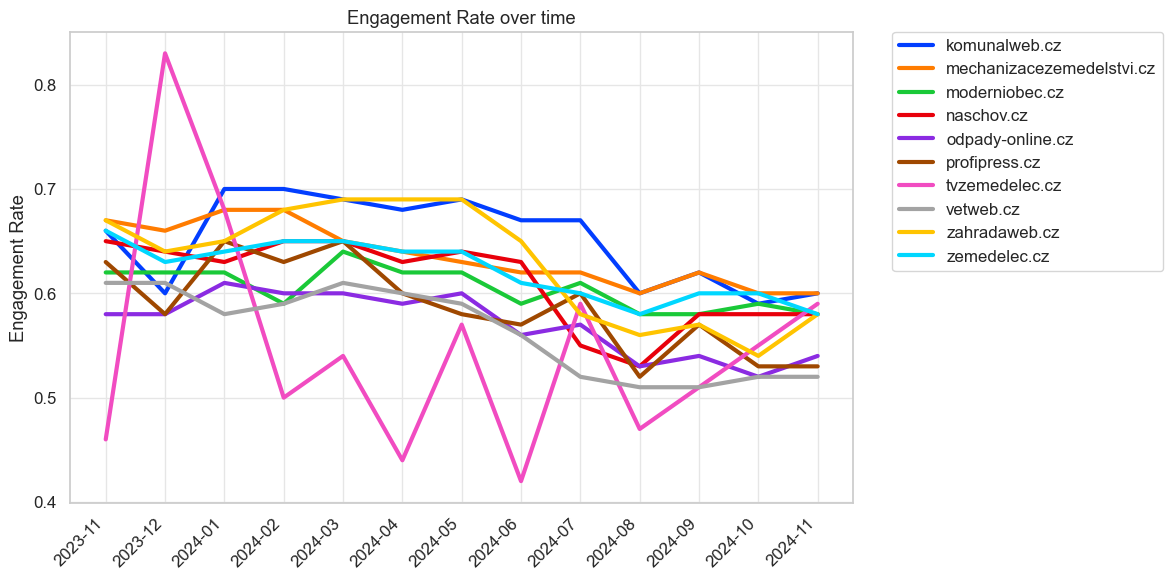

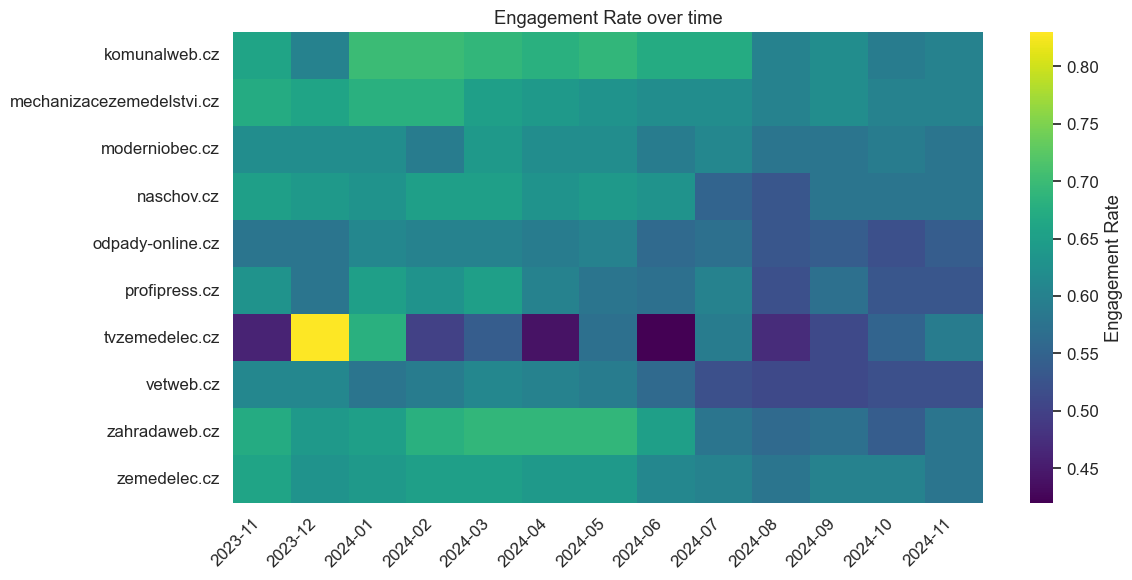

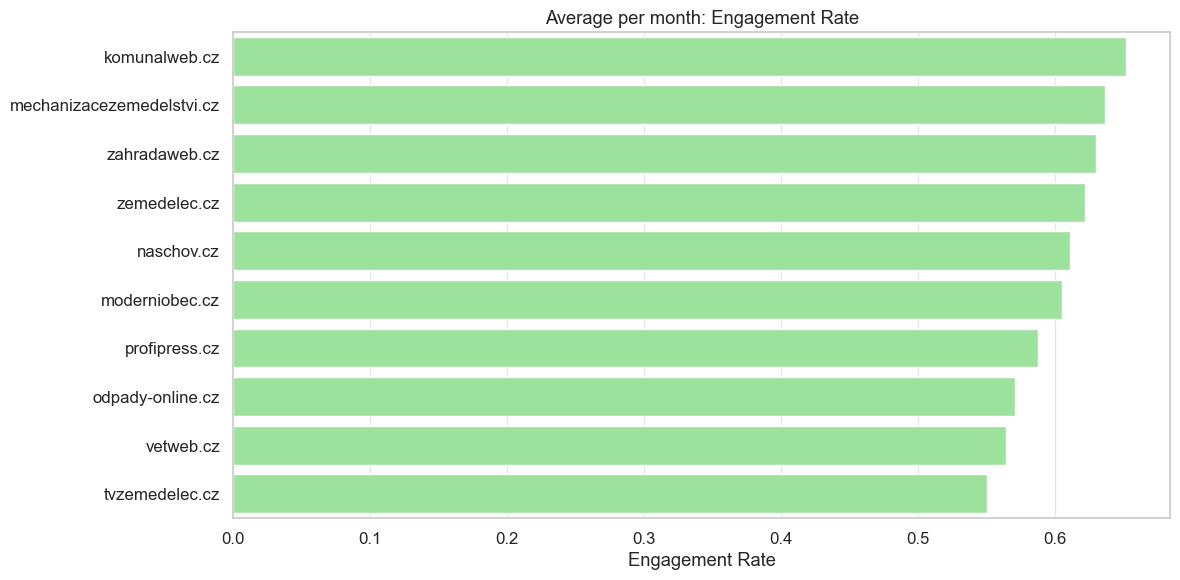

In [152]:
comparison_mean(df_websites, "engagement_rate")

**New users ratio**

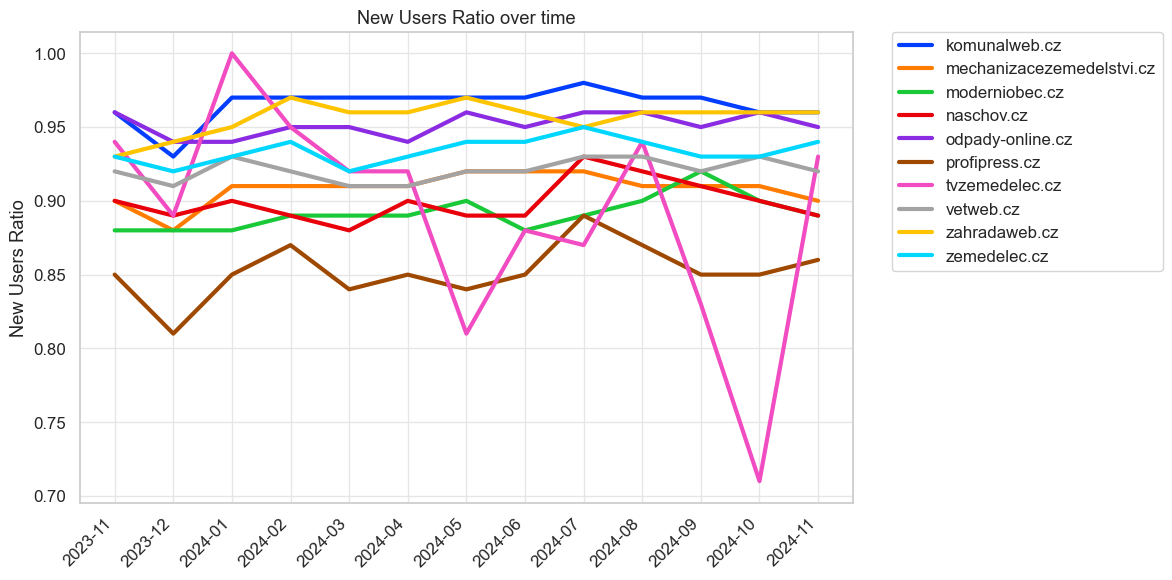

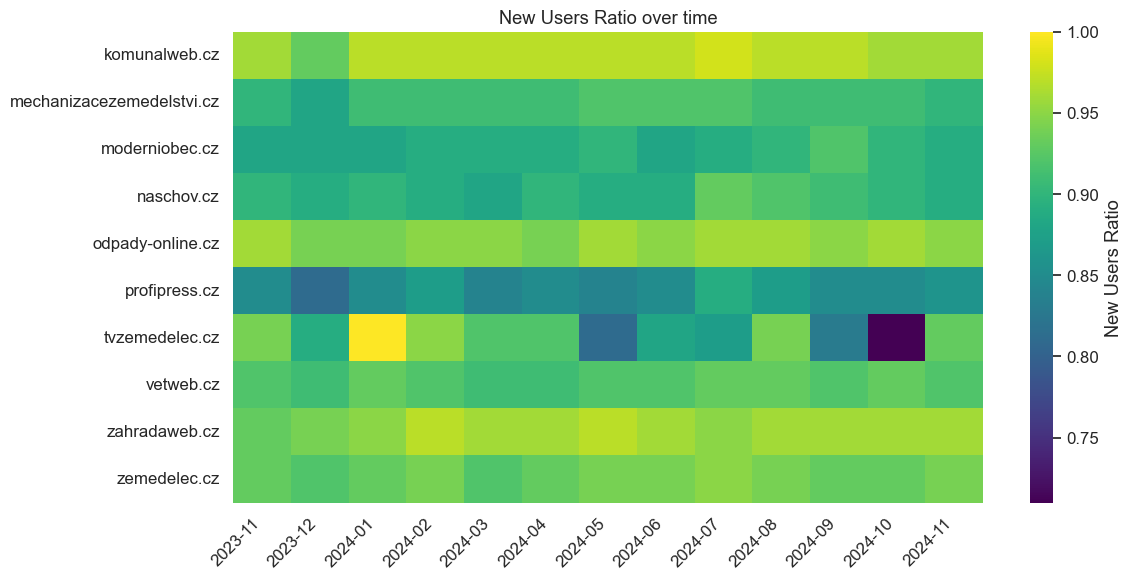

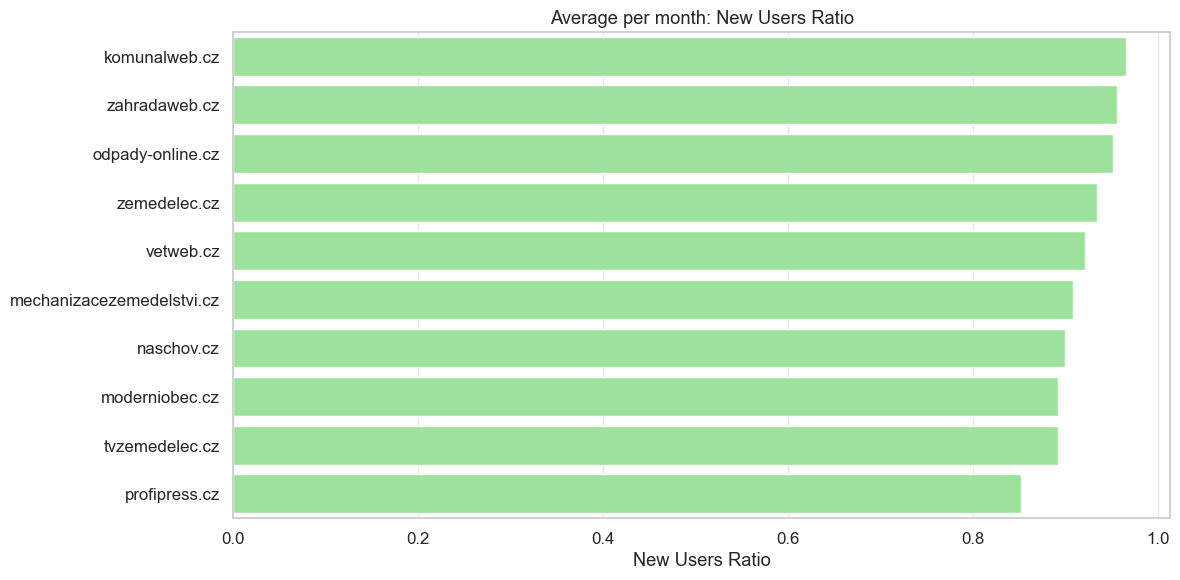

In [153]:
comparison_mean(df_websites, "new_users_ratio")